<a href="https://colab.research.google.com/github/bestkante/Stroke-Prediction-EDA-and-Descriptive-Modelling/blob/main/Stroke_Prediction_EDA_and_Descriptive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stroke Prediction EDA and Descriptive Modeling

### By: Mory Kante
Author Name

### Date:
2024-12-15

### Description:

The project aims to identify key factors driving stroke risk and build a machine learning model to predict stroke occurrences. This can help raise awareness among individuals and assist healthcare providers and insurers in estimating risks and associated costs. Logistic regression will be used as a baseline for binary classification due to its simplicity and interpretability.
•	Problem Statement:
The project addresses the following goals:
1.	Descriptive Analysis
Explore key drivers of stroke occurrences, such as age, BMI, hypertension, heart disease, and lifestyle choices.
Use insights to provide actionable recommendations for individuals, healthcare providers, and insurers.
2.	Predictive Modeling
Develop a machine learning model to predict stroke risk based on demographic, lifestyle, and health-related factors.
Enable timely intervention and resource allocation by identifying high-risk individuals.


## 📚 Import  libraries

In [ ]:
# base libraries for data science

# Data Manipulation.
import pandas as pd
import numpy as np

# Data Visualization.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Imputer
from sklearn.impute import KNNImputer

# Data Standardization.
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer

# Encode variables
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# DS Division.
from sklearn.model_selection import train_test_split

# Data Balancing.
from imblearn.over_sampling import SMOTE

# Modelling
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Save Models.
from joblib import dump, load
#from pickle import dump, load

# Warnings.
import warnings
warnings.filterwarnings("ignore")

# Time.
import time

# Color Palette.
palette = sns.husl_palette(h=.5)
palette_matrix = sns.color_palette("light:#5A9", as_cmap=True)

## Custom prerequits functions

In [ ]:
# Data inspection function
def data_inspection(df):
    print("Data Information:")
    print(df.info())
    print("Data Shape:", df.shape)
    print("\nDuplicate values:")
    print(df.duplicated().sum())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nUnique Values per column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()}")
    print("\nstroke Distribution")
    print(df['stroke'].value_counts())

In [ ]:
# Handles missing values using different imputation methods

def handle_missing_values(df, method='knn', n_neighbors=5):

    df_imputed = df.copy()
    if method == 'knn':
        # Use KNNImputer for numeric columns only
        numeric_cols = df_imputed.select_dtypes(include=np.number).columns
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_imputed[numeric_cols] = imputer.fit_transform(df_imputed[numeric_cols])
    # Add more imputation methods
    elif method == 'mean':
      df_imputed = df_imputed.fillna(df_imputed.mean())
    elif method == 'median':
      df_imputed = df_imputed.fillna(df_imputed.median())

    return df_imputed

In [ ]:
def separate_features(df):
    categorical_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            categorical_features.append(column)
        elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
            continuous_features.append(column)
        else:
            print(f'Unhandled data type in column "{column}": {df[column].dtype}')

    return categorical_features, continuous_features


In [ ]:
def encode_categorical_variables(df, columns_to_encode, encoding_type='onehot'):

    df_encoded = df.copy()

    for column in columns_to_encode:
        if column in df_encoded.columns and df_encoded[column].dtype == 'object':
            if encoding_type == 'onehot':
                dummies = pd.get_dummies(df_encoded[column], prefix=column, drop_first=True)
                df_encoded = pd.concat([df_encoded, dummies], axis=1)
                df_encoded = df_encoded.drop(column, axis=1)
            elif encoding_type == 'label':
                le = LabelEncoder()
                df_encoded[column] = le.fit_transform(df_encoded[column])
            elif encoding_type == 'ordinal':
                oe = OrdinalEncoder()
                df_encoded[column] = oe.fit_transform(df_encoded[[column]])
            else:
                print(f"Invalid encoding type '{encoding_type}' for column '{column}'. Skipping...")
        else:
            print(f"Column '{column}' not found or not categorical. Skipping...")
    return df_encoded

In [ ]:
# Divide the DF into the set of Training, Validation and Test.
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)


In [ ]:
# Remove Target (Separates the Label from the Features)
def remove_labels(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name].copy()
    return (X, y)

## 💾 Load data

Dataset kaggle : https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Ffedesoriano%2Fstroke-prediction-dataset

In [ ]:

# The data is converted to a dataframe.
df_original = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
# Main dataframe is created.
df = df_original.copy()

# Dataframe is created for EDA (Assumptions).
df_eda = df.copy()
# Dataframe for data cotegorization
df_cat_bin = df.copy()
# Dataframe is created for Modeling
df_m = df.copy()

## Data inspection and Understanding

In [ ]:
# Data view.
print("\nFirst 5 rows:")
df.head(5)
print("\nLast 5 rows:")
print(df.tail())


First 5 rows:

Last 5 rows:
         id  gender   age  hypertension  heart_disease ever_married  \
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
5105       0  
5106       0  
5107       0  
510

In [ ]:
# Data impection
data_inspection(df)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
Data Shape: (5110, 12)

Duplicate values:
0

Missing Values:
id                     0
gender                 0
age                    

* Observation:
* Attributes Details:
 * The dataset contains 12 columns and 5110 entries. Here's a summary of the dataset:
 * 1.	id: Patient unique ID (integer, no null values).
 * 2.	gender: Patient gender (categorical, values: "Male", "Female", or "Other").
 * 3.	age: Age of the patient (continuous float, no null values).
 * 4.	hypertension: Indicates if the patient has hypertension (binary, 0 or 1).
 * 5.	heart disease: Indicates if the patient has heart disease (binary, 0 or 1).
 * 6.	ever married: Marital status of the patient (categorical, "Yes" or "No").
 * 7.	work type: Patient's work type (categorical: "children", "Govt_job", "Never worked", "Private", "Self-employed").
 * 8.	Residence type: Patient's residence (categorical: "Rural" or "Urban").
 * 9.	avg_glucose_level: Average glucose level in blood (continuous float, no null values).
 * 10.	bmi: Body Mass Index (continuous float, has 201 missing values).
 * 11.	smoking status: Smoking habits (categorical: "formerly smoked", "never smoked", "smokes", or "Unknown").
 * 12.	stroke: Target variable indicating stroke occurrence (binary, 1 or 0).

* Missing Values: The bmi column has 201 missing values that require preprocessing.
* Categorical Variables: There are multiple categorical variables, including gender, ever married, work type, Residence type, and smoking status, that will need encoding.
* Continuous Variables: Variables like age, avg_glucose_level, and bmi need normalization or scaling.
* Class Imbalance: The stroke column needs to be explored further to check for imbalanced data.


* Review of Features with Small Categories.

In [ ]:
# Gets the names of the categorical features.
features_cat = df.select_dtypes(include=('object')).columns

# The features with categories of a size smaller than 5% of the data are obtained.
for i in features_cat:
    count = round(df[i].value_counts() / len(df) * 100, 2)
    for j in count:
        if j < 3:
            print(f"\nSize in % of Categories in {i}:\n{count}\n")


Size in % of Categories in gender:
gender
Female    58.59
Male      41.39
Other      0.02
Name: count, dtype: float64


Size in % of Categories in work_type:
work_type
Private          57.24
Self-employed    16.03
children         13.44
Govt_job         12.86
Never_worked      0.43
Name: count, dtype: float64



Observations.
* Features with very small categories could generate noise to the classification model.

* The "Gender" features have the "Other" category which has only 0.02% of the data that is equal to only 1 patient which can be noicy.

* The "Type Work" feature has the "Never Worked" category, which has only 0.44% of the data, which is equivalent to 22 patients.

* Review of Target Values.

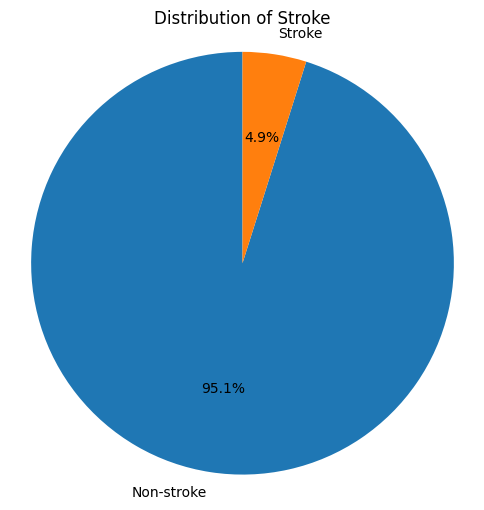

stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


In [ ]:
# Review of Target Values.
stroke_counts = df['stroke'].value_counts()
# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(stroke_counts, labels=['Non-stroke', 'Stroke'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Stroke')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
# Check for class imbalance and explore feature distributions
print(df['stroke'].value_counts(normalize=True)*100)

* Observations.
  * The distribution of the stroke target variable shows severe imbalance: 0 (No Stroke): 4861 instances and 1 (Stroke): 249 instances.

  * 95% of patients have not had a stroke.

  * Only 5% of patients in the entire dataset have had a stroke.

## Data preprocessing for Analysis


### Delete of feature "id"

In [ ]:
# Delete of feature "id".
df = df.drop('id', axis=1)

### Handling Missing values

In [ ]:
df_imputed = handle_missing_values(df, method='knn')
print(df_imputed.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


### Data Exportation and Categorization for Analysis

In [ ]:
# BMI: Categorize into "Underweight," "Normal," "Overweight," and "Obese."
# Age: Create bins for "Young," "Middle-aged," and "Elderly."
# Glucose Levels: Classify into "Normal," "Pre-Diabetic," and "Diabetic" based on thresholds.

def categorize_data(df):
    df_categorized = df.copy()

    # BMI Categorization
    def categorize_bmi(bmi):
        if bmi < 18.5:
            return "Underweight"
        elif 18.5 <= bmi < 25:
            return "Normal"
        elif 25 <= bmi < 30:
            return "Overweight"
        else:
            return "Obese"

    df_categorized['BMI_Category'] = df_categorized['bmi'].apply(categorize_bmi)


    # Age Categorization
    def categorize_age(age):
        if age < 45:
            return "Young"
        elif 45 <= age < 65:
            return "Middle-aged"
        else:
            return "Elderly"

    df_categorized['Age_Category'] = df_categorized['age'].apply(categorize_age)

    # Glucose Level Categorization
    def categorize_glucose(glucose):
        if glucose < 100:  # Example thresholds, adjust as needed
            return "Normal"
        elif 100 <= glucose < 126:
            return "Pre-Diabetic"
        else:
            return "Diabetic"

    df_categorized['Glucose_Category'] = df_categorized['avg_glucose_level'].apply(categorize_glucose)

    return df_categorized

df_with_categories = categorize_data(df_cat_bin)
# print(df_with_categories.head())



In [ ]:
# copy clean data in df_eda, df_corr df_cat and df_m and export it.
df_eda = df_imputed.copy()

df_cat_bin = df_imputed.copy()


In [ ]:
# export clean_df_stroke.csv and clean_df_with_categories
df_clean = handle_missing_values(df_original, method='knn').copy()
df_clean .to_csv('clean_stroke_data .csv', index=False)

clean_df_with_categories = categorize_data(df_clean).copy()
clean_df_with_categories.to_csv('clean_categorize_stroke_data .csv', index=False)

### Separate Features into categorical and continuous

In [ ]:
categorical_features, continuous_features = separate_features(df_eda)

In [ ]:
continuous_features.remove('stroke')

In [ ]:
df_m[categorical_features].dtypes

,0
gender,object
ever_married,object
work_type,object
Residence_type,object
smoking_status,object


In [ ]:
df_m[continuous_features].dtypes

,0
age,float64
hypertension,int64
heart_disease,int64
avg_glucose_level,float64
bmi,float64


## Exploratory Data Analysis

### Samary statistics

In [ ]:
# Statistical information is obtained.
print("\nDescriptive Statistics:")
df_eda.describe(include='all').fillna('-').round(1)


Descriptive Statistics:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.0,5110.0,5110.0,5110,5110,5110,5110.0,5110.0,5110,5110.0
unique,3,-,-,-,2,5,2,-,-,4,-
top,Female,-,-,-,Yes,Private,Urban,-,-,never smoked,-
freq,2994,-,-,-,3353,2925,2596,-,-,1892,-
mean,-,43.226614,0.097456,0.054012,-,-,-,106.147677,28.944513,-,0.048728
std,-,22.612647,0.296607,0.226063,-,-,-,45.28356,7.767494,-,0.21532
min,-,0.08,0.0,0.0,-,-,-,55.12,10.3,-,0.0
25%,-,25.0,0.0,0.0,-,-,-,77.245,23.7,-,0.0
50%,-,45.0,0.0,0.0,-,-,-,91.885,28.2,-,0.0
75%,-,61.0,0.0,0.0,-,-,-,114.09,33.1,-,0.0


* Observstion:  
  * In all the characteristics there are 5,110 copies except the characteristic "bmi".
  * Summary of Numerical Variables
    * age: Ranges from 0.08 years (infants) to 82 years, with a mean age of ~43.2 years.
    * bmi: Ranges from 10.3 to 97.6, with an average of ~28.9 (excluding NaNs).
    * avg_glucose_level: Ranges from 55.12 to 271.74 mg/dL.

  * The scales in the numerical characteristics are very different.

  * The dispersion of the data in characteristics such as "age" and "Glucose level is high.

### Data discovery and Visualisation.

* Univariate Analysis

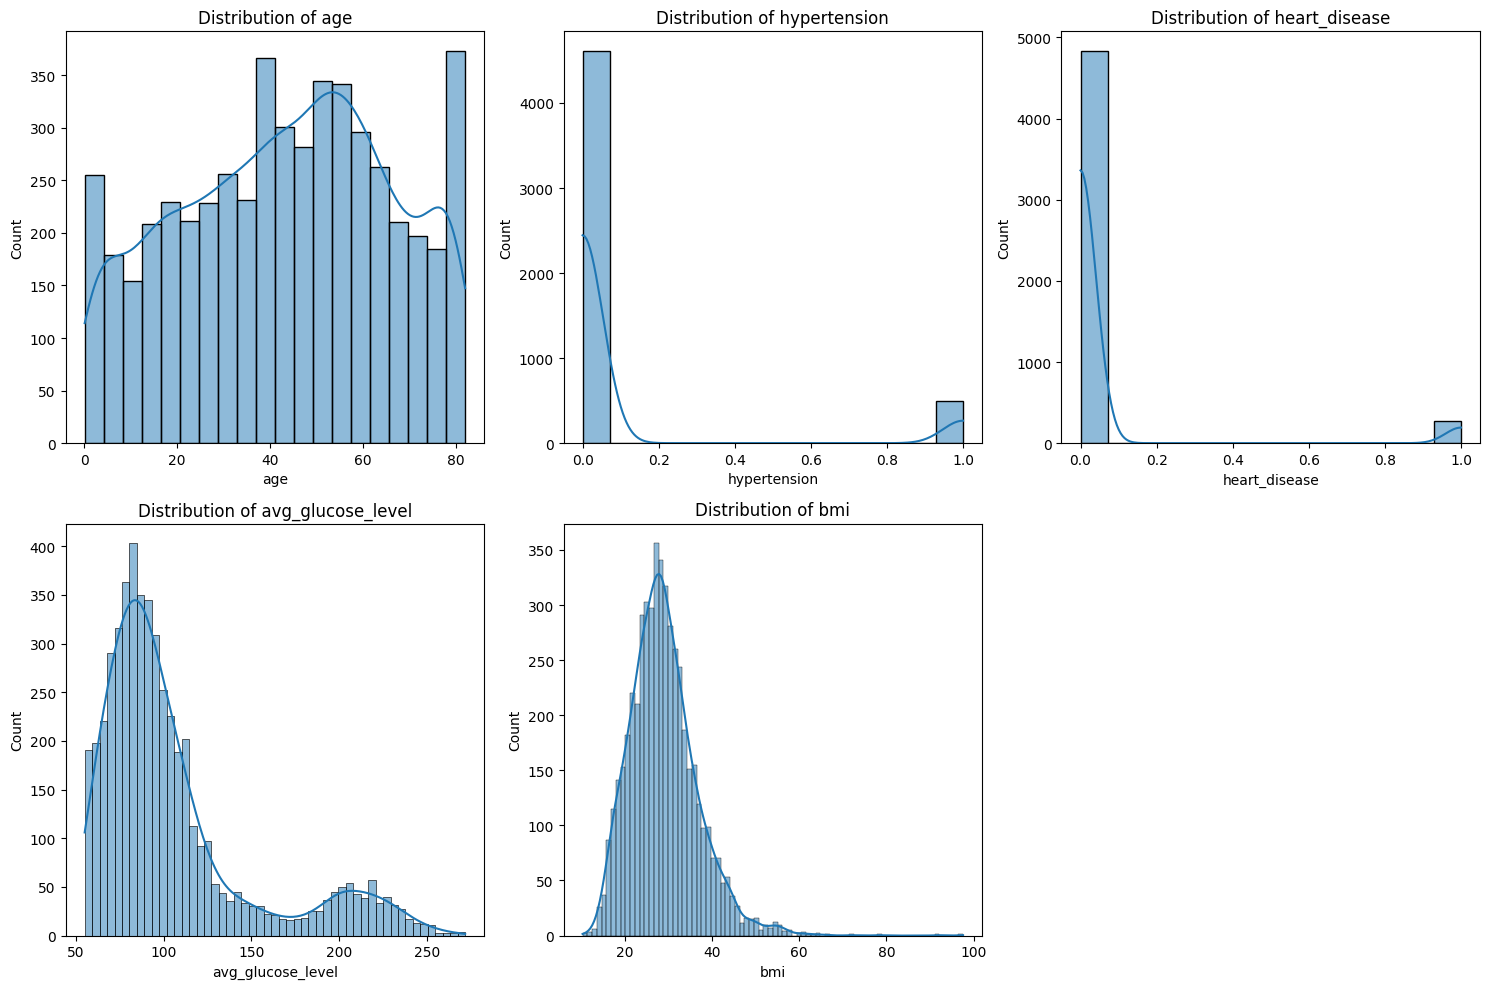

In [ ]:
# Feature distributions for numerical features
# continuous_features
# Calculate the number of rows and columns for the subplots
num_plots = len(continuous_features)
ncols = 3  # Number of columns in the subplot grid
nrows = (num_plots + ncols - 1) // ncols  # Calculate the number of rows

# Create the subplot grid
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the numerical features and create distribution plots
for i, feature in enumerate(continuous_features):
    sns.histplot(df_eda[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Observation:
*Distribution of age:

  * This histogram shows the distribution of age among the data points.
The x-axis represents the age, and the y-axis shows the count or frequency of individuals at each age.
The distribution appears to be a bell-shaped curve, indicating that the majority of the data points are concentrated around the middle ages, with fewer individuals at the younger and older ages.
*Distribution of avg_glucose_level:

  * This histogram displays the distribution of average glucose levels among the data points.
The x-axis represents the glucose level, and the y-axis shows the count or frequency of individuals with each glucose level.
The distribution has a distinct peak, suggesting that the majority of the data points have a similar average glucose level, with fewer individuals at the higher and lower ends of the spectrum.
* Distribution of bmi:

  * This histogram shows the distribution of body mass index (BMI) among the data points.
The x-axis represents the BMI values, and the y-axis shows the count or frequency of individuals with each BMI.
The distribution has a prominent peak, indicating that the majority of the data points have a similar BMI, with fewer individuals at the lower and higher ends of the BMI range.
* Distribution of hypertension:

  * This histogram depicts the distribution of hypertension among the data points.
The x-axis represents the hypertension values, and the y-axis shows the count or frequency of individuals with each hypertension level.
The distribution has a sharp peak, suggesting that the majority of the data points have a similar hypertension level, with fewer individuals at the higher and lower ends of the hypertension range.
* Distribution of heart_disease:

  * This histogram displays the distribution of heart disease among the data points.
The x-axis represents the heart disease values, and the y-axis shows the count or frequency of individuals with each heart disease level.
The distribution has a distinct peak, indicating that the majority of the data points have a similar heart disease level, with fewer individuals at the higher and lower ends of the heart disease range.
* Overall, these distributions provide insights into the characteristics of the data points, such as the concentration of individuals around certain age, glucose level, BMI, hypertension, and heart disease values. This information can be useful for understanding the underlying patterns and trends in the data.

* Feature distributions for categorical features and target

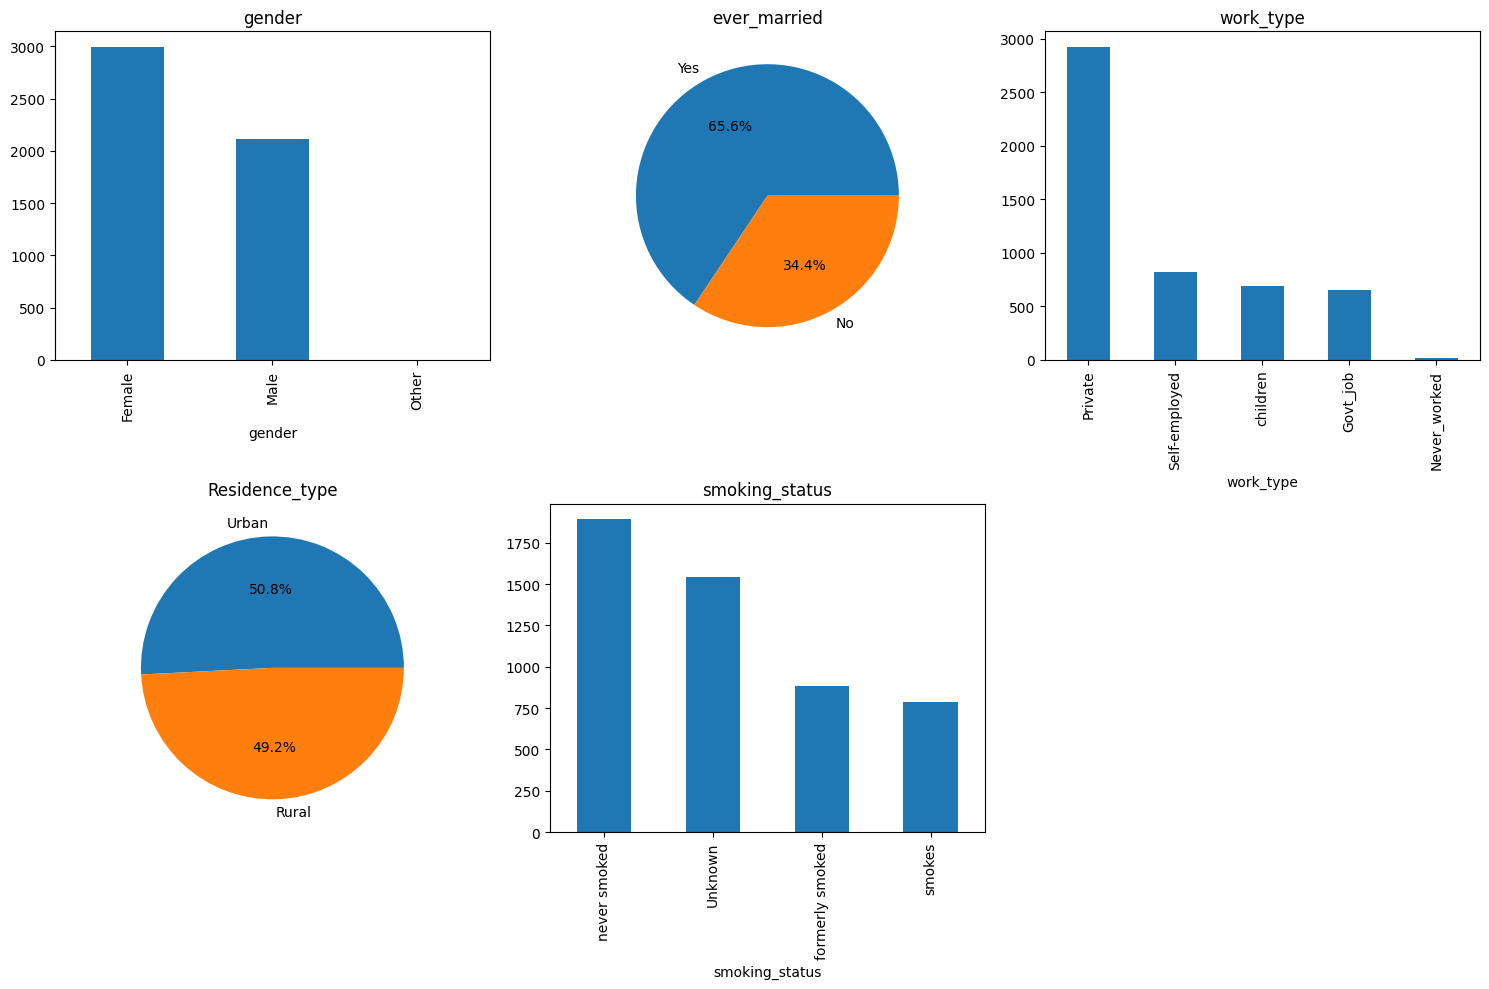

In [ ]:
# Feature distributions for categorical features and target
# categorical_features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axes array
axes = axes.flatten()

pie_features = ['ever_married', 'Residence_type']
bar_features = [feature for feature in categorical_features if feature not in pie_features]


for i, feature in enumerate(categorical_features):
    ax = axes[i]
    if feature in pie_features:
        df[feature].value_counts().plot.pie(autopct='%1.1f%%', ax=ax)
    else:
        df[feature].value_counts().plot(kind='bar', ax=ax)

    ax.set_title(feature)
    ax.set_ylabel('')  # Remove y-axis label


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Observation:
* Gender:

  * The graph shows the distribution of gender, with the majority being Female (2,747) and the minority being Male (2,118).
* Ever Married:

  * This pie chart shows the marital status, where 65.6% of the individuals are "Yes" (ever married) and 34.4% are "No" (never married).
* Work Type:

  * This graph displays the distribution of work types, with the highest being Private (2,825), followed by Self-employed (1,030), Government_job (686), and Never_worked (245).
* Residence Type:

  * The pie chart shows the distribution of residence type, with 50.8% being Urban and 49.2% being Rural.
* Smoking Status:

  * This graph depicts the smoking status, with the highest being never smoked (1,593), followed by formerly smoked (1,274), smokes (744), and Unknown (230).
* The information provided in these graphs gives insights into the demographics, marital status, work types, residence types, and smoking habits of the individuals in the dataset. This data can be useful for understanding the characteristics of the population being studied.

* Bivariate Analysis
* Explore relationships between numerical_features and the target variable

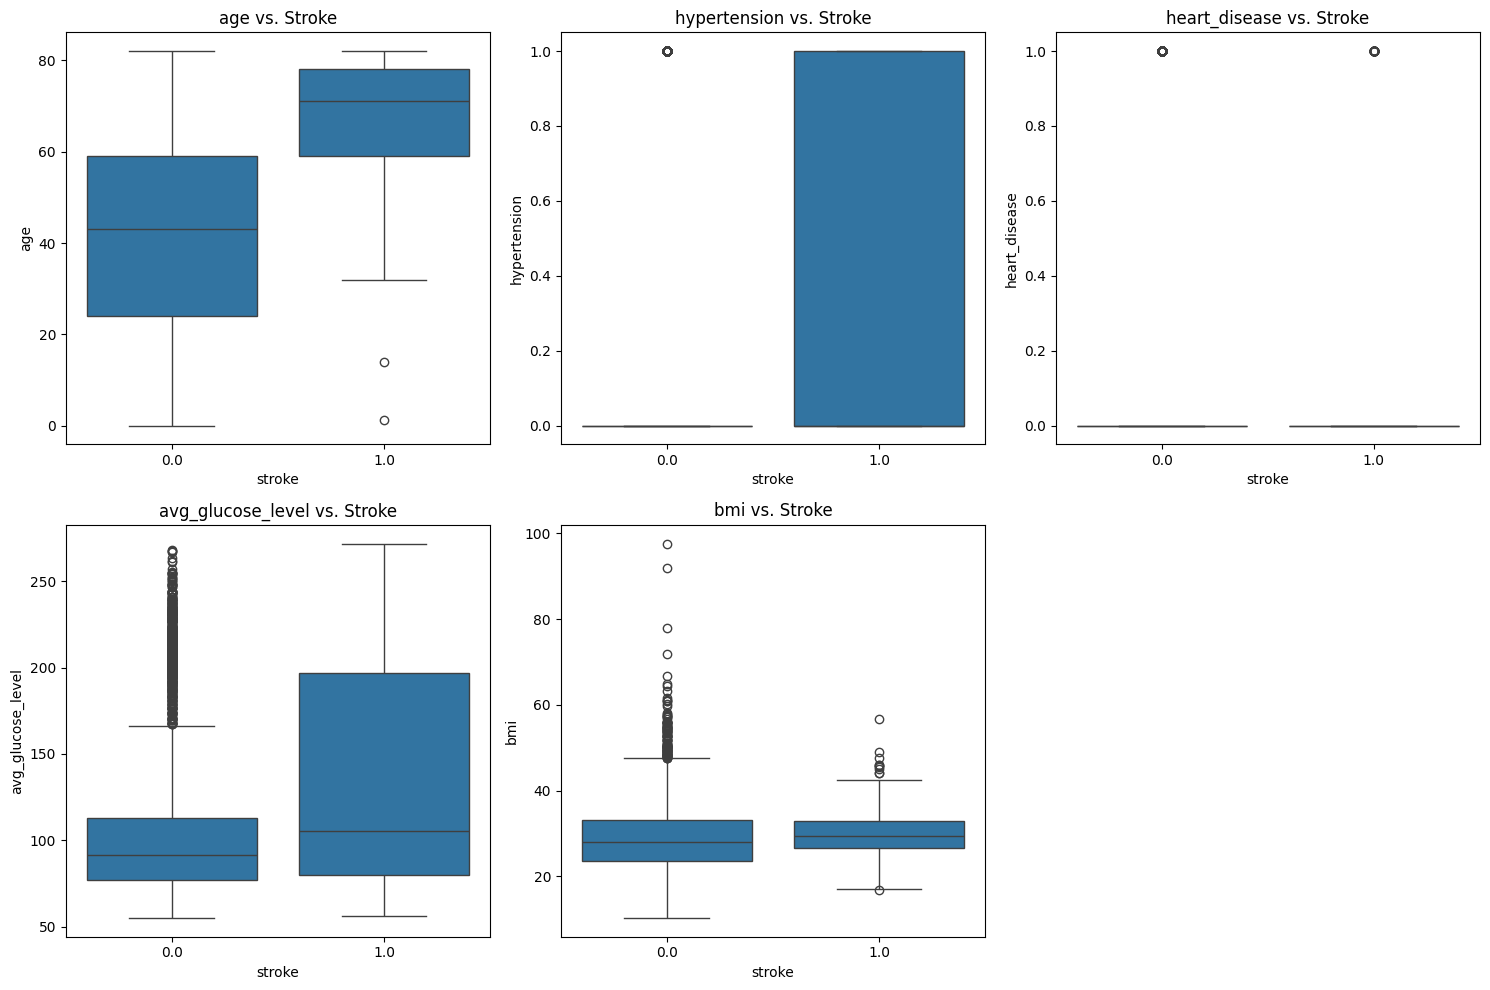

In [ ]:
# Explore relationships between numerical_features and the target variable

# Create subplots for numerical features vs. target variable
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    sns.boxplot(x='stroke', y=feature, data=df_eda, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Stroke')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Observation:
* Age vs. Stroke:

  * This graph shows the distribution of age between individuals with and without stroke. The data points indicate that individuals with stroke tend to be older compared to those without stroke.
* Avg Glucose Level vs. Stroke:

  * This graph depicts the average glucose level for individuals with and without stroke. The data suggests that individuals with stroke have higher average glucose levels compared to those without stroke.
* BMI vs. Stroke:

  * This graph illustrates the relationship between body mass index (BMI) and stroke. The data points suggest that individuals with higher BMI values are more likely to have a stroke.
* Hypertension vs. Stroke:

  * This graph shows the distribution of hypertension levels between individuals with and without stroke. The data indicates that individuals with stroke have higher hypertension levels compared to those without stroke.
* Heart Disease vs. Stroke:

  * This graph depicts the relationship between heart disease and stroke. The data points suggest that individuals with stroke are more likely to have heart disease compared to those without stroke.
* These additional graphs provide more insights into the potential risk factors and associations between various health indicators and the occurrence of stroke. The data suggests that factors such as age, glucose level, BMI, hypertension, and heart disease may be linked to the likelihood of experiencing a stroke.

* Explore relationships between categorical features and the target variable

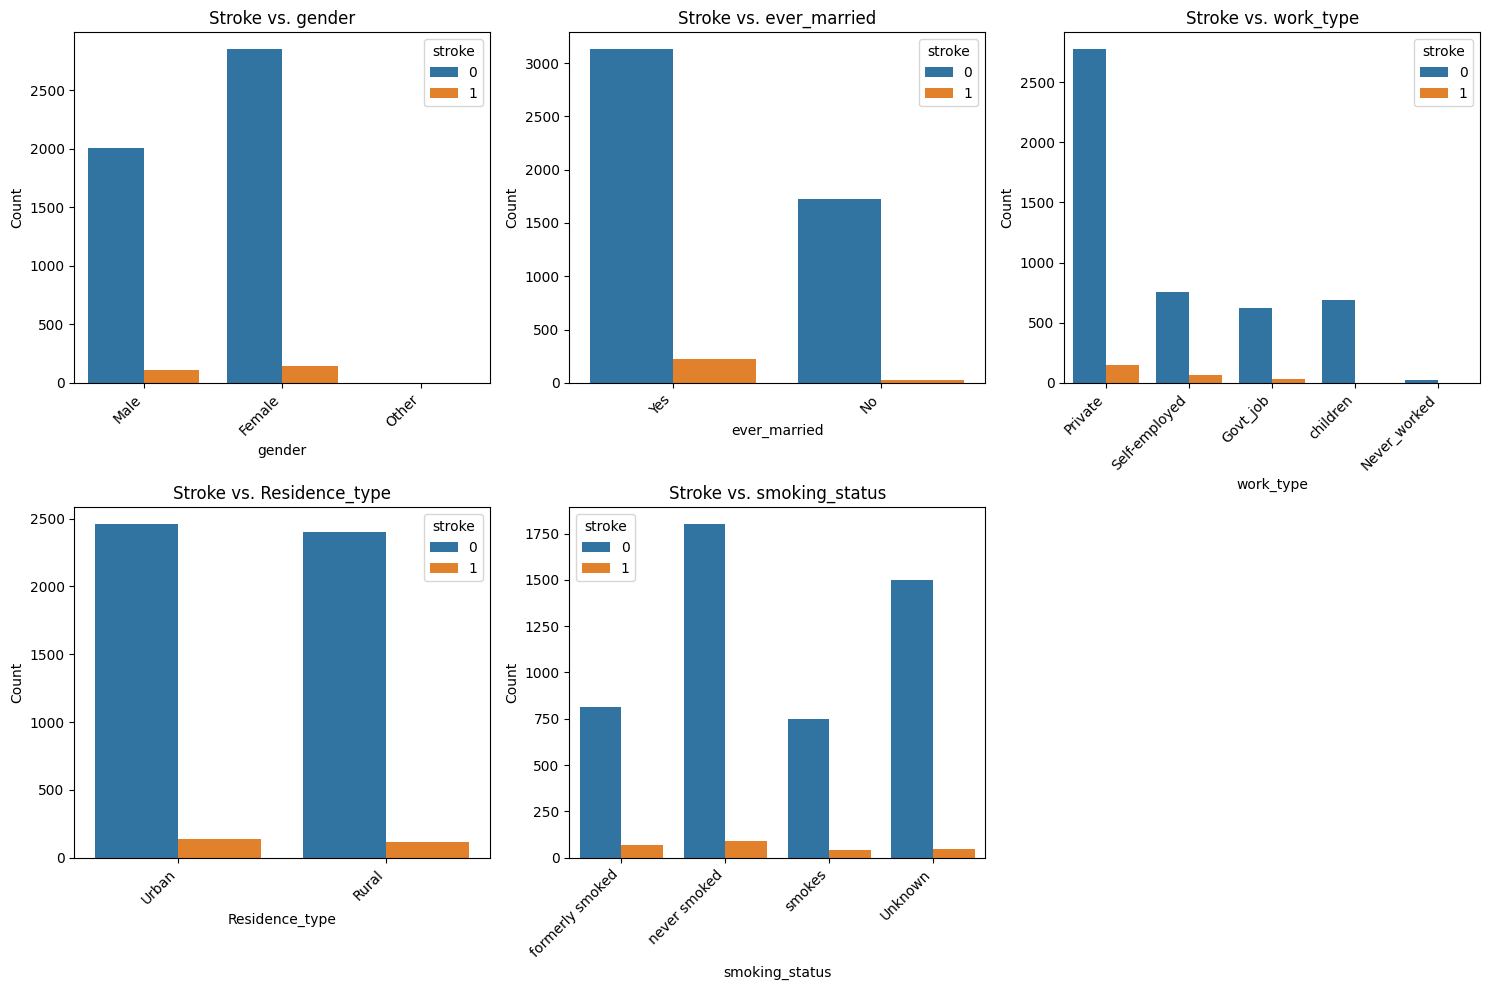

In [ ]:
# Explore relationships between categorical features and the target variable
categorical_features
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
gs = gridspec.GridSpec(2, 3)  # Create a 2x3 grid for subplots

for i, col in enumerate(categorical_features):
    ax = plt.subplot(gs[i])
    # Check if the column exists in df_eda before plotting
    if col in df.columns:
        sns.countplot(x=col, hue='stroke', data=df, ax=ax)
        ax.set_title(f'Stroke vs. {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    else:
        print(f"Column '{col}' not found in df_eda")

plt.tight_layout() # Ensures subplots do not overlap
plt.show()

* Observation:
* Stroke vs. Gender:

  * This graph shows the distribution of stroke cases by gender. The data indicates that females have a higher count of stroke cases (2,748) compared to males (2,118).
* Stroke vs. Ever Married:

  * This graph depicts the relationship between stroke and marital status. The data suggests that individuals who have ever been married have a higher count of stroke cases (2,575) compared to those who have never been married (1,291).
* Stroke vs. Work Type:

  * This graph illustrates the distribution of stroke cases across different work types. The data shows that individuals with a "Private" work type have the highest count of stroke cases (1,721), followed by "Self-employed" (641), "Government_job" (412), and "Never_worked" (152).
* Stroke vs. Residence Type:

  * This graph shows the distribution of stroke cases by residence type. The data indicates that individuals living in urban areas have a higher count of stroke cases (1,860) compared to those living in rural areas (1,006).
* Stroke vs. Smoking Status:

  * This graph depicts the relationship between stroke and smoking status. The data suggests that individuals who have "never smoked" have the highest count of stroke cases (1,015), followed by "formerly smoked" (788), "smokes" (451), and "Unknown" (142).
* These additional graphs provide more insights into the potential risk factors and associations between various demographic, socioeconomic, and lifestyle factors and the occurrence of stroke. The data highlights the disparities in stroke cases across different gender, marital status, work types, residence types, and smoking habits.

# 👷 Data preparation or Feature Engineering

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from prettytable import PrettyTable
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


### Encode categorical variables for Correlation Analysis

In [ ]:
df_m = df_imputed.copy()

In [ ]:
df_encode = encode_categorical_variables(df_m, categorical_features, encoding_type='onehot')

## Correlation matrix  and P value

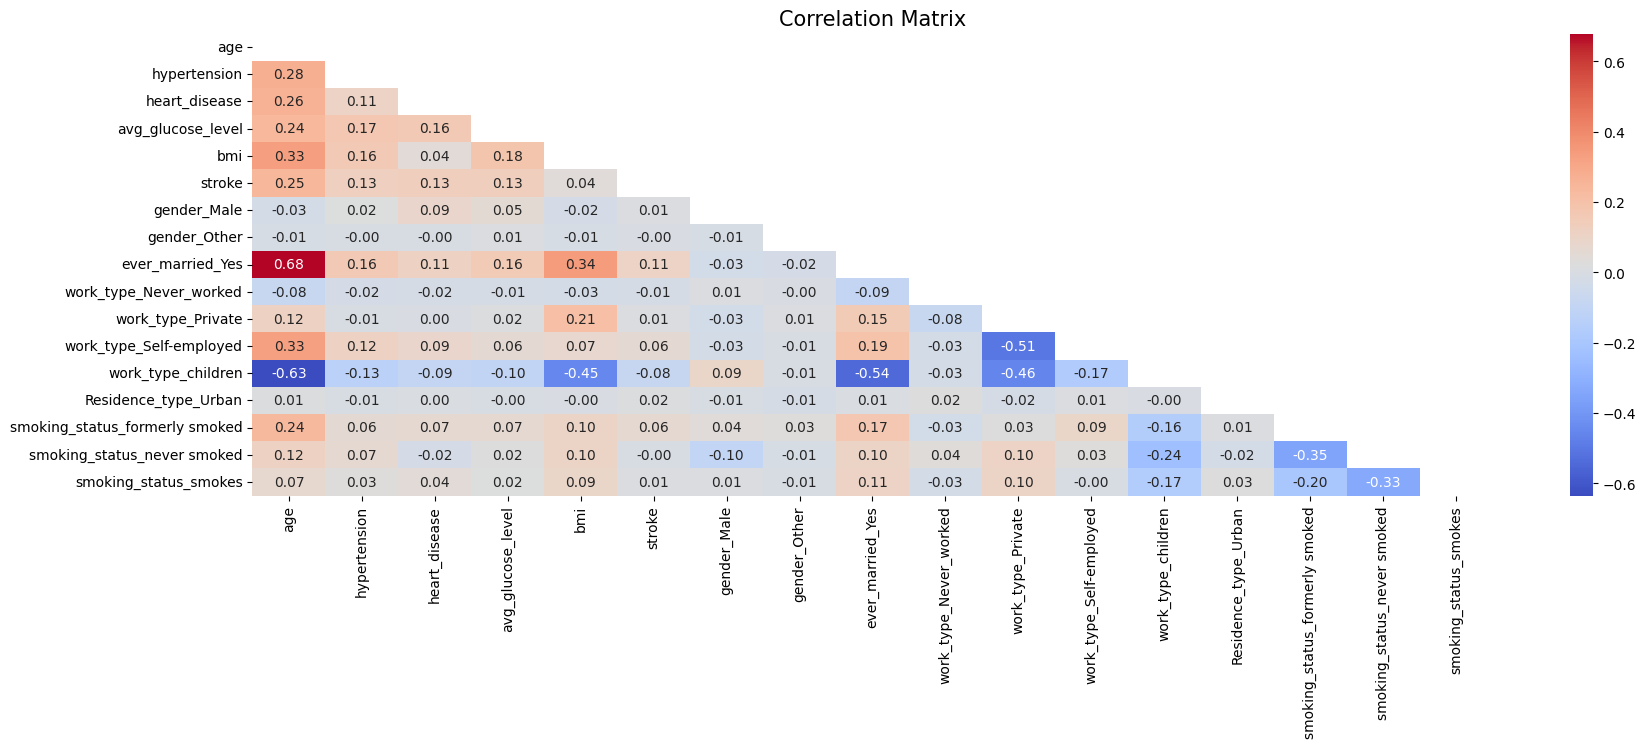

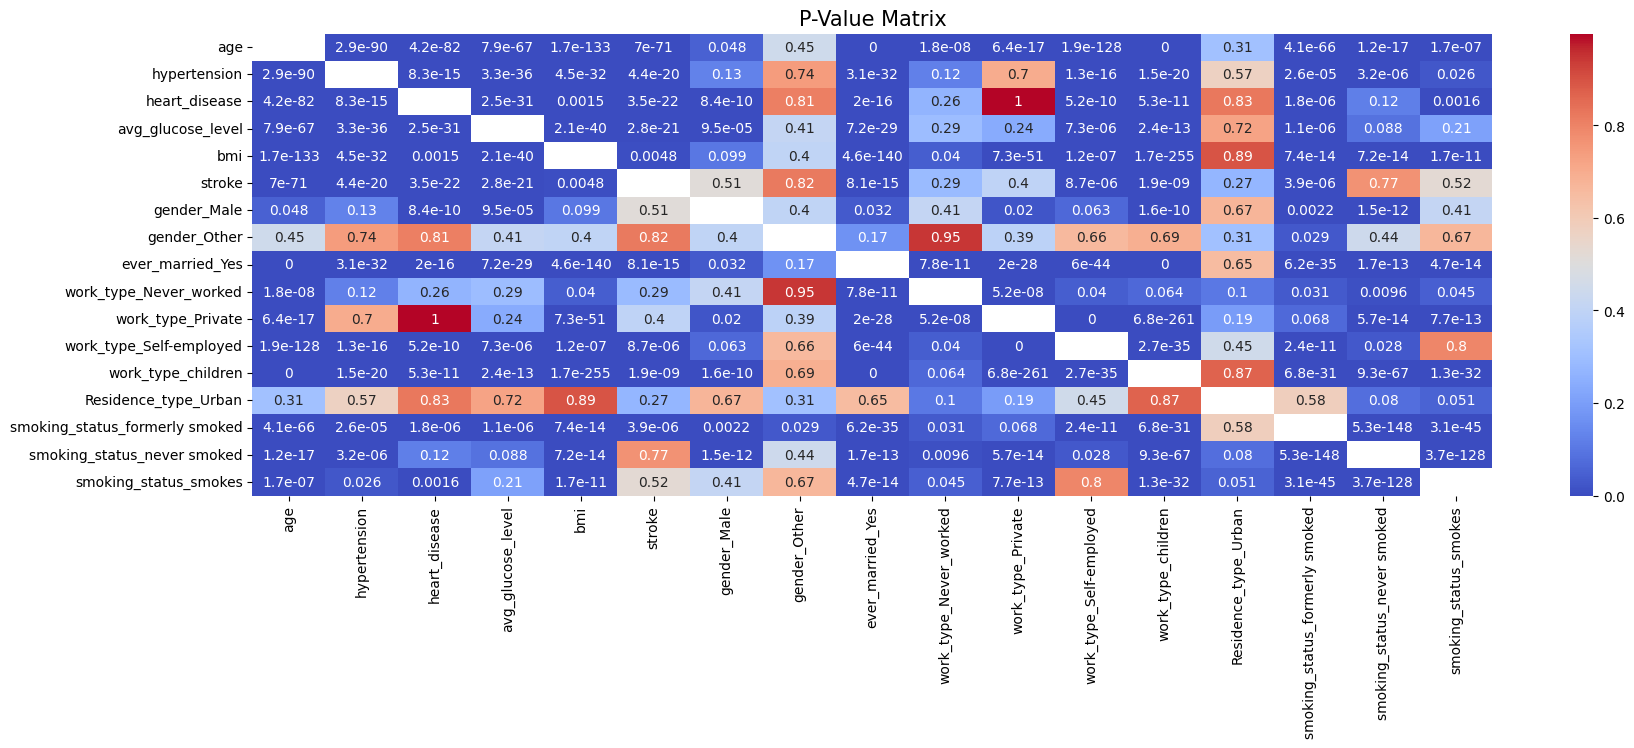

In [ ]:
def calculate_pvalues(df):
    """Calculate p-values for the correlation matrix."""
    df_cols = df.columns
    pvalues = pd.DataFrame(np.zeros((len(df_cols), len(df_cols))), columns=df_cols, index=df_cols)
    for i in range(len(df_cols)):
        for j in range(len(df_cols)):
            if i == j:
                pvalues.iloc[i, j] = np.nan  # No p-value for self-correlation
            else:
                _, pvalue = pearsonr(df[df_cols[i]], df[df_cols[j]])
                pvalues.iloc[i, j] = pvalue
    return pvalues

# Correlation and p-value matrices
df_corr = df_encode.corr()
pvalues = calculate_pvalues(df_encode)

# Plot Correlation Matrix
plt.figure(figsize=(20, 6))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, mask=np.triu(df_corr))
plt.title('Correlation Matrix', fontsize=15)
plt.show()

# Plot P-Value Matrix
plt.figure(figsize=(20, 6))
sns.heatmap(pvalues, annot=True, fmt='.2g', cmap='coolwarm', cbar=True, mask=np.triu(pvalues.isnull()))
plt.title('P-Value Matrix', fontsize=15)
plt.show()


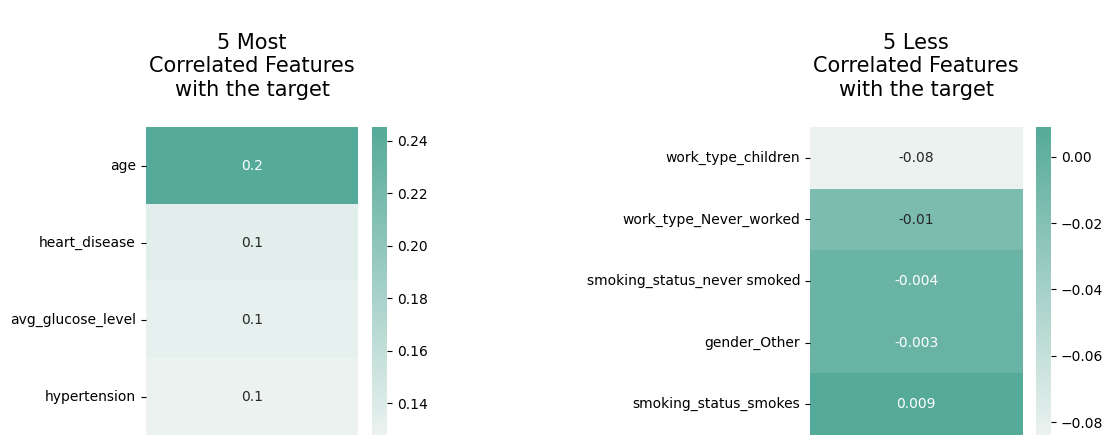

In [ ]:
# DF with the features with the highest correlation and the target is removed.
corr_higher = pd.DataFrame(df_corr['stroke'].sort_values(ascending=False)).head()
corr_higher = corr_higher.drop('stroke', axis=0)

# DF with the features with less correlation.
corr_less = pd.DataFrame(df_corr['stroke'].sort_values()).head()

# List of DFs of Correlations
corr_ls = [corr_higher, corr_less]

# Plot Description.
description = [str(f'\n5 Most\nCorrelated Features\nwith the target\n'), str(f'5 Less\nCorrelated Features\nwith the target\n')]

# Grid Plot.
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace=1.5, hspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(corr_ls):
    ax = plt.subplot(gs[i])
    sns.heatmap(corr_ls[i], annot=True, fmt='.1g', cmap=palette_matrix, cbar=True)
    ax.set_title(description[i], fontsize=15)
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
plt.show()


* Proposed Variables for Model from correlation analysis and P-Value:
  * Age: Strong correlations with multiple key variables like marriage, work type, health factors (hypertension, heart disease, stroke, BMI).
  * BMI: Moderately correlated with age and work type (self-employed), both of which are significant.
  * Hypertension and Heart Disease: Correlated with age and smoking status, but weakly. These could be useful for exploring health-related outcomes.
  * Ever Married (Yes): Strong correlation with age and work type, providing insights into life-stage patterns.
  * Work Type (Children, Self-Employed): Significant relationships with age, BMI, and marriage, offering valuable information on socio-economic conditions
* "Age" is the feature that has the highest correlation with the target ("Stroke") with a low correlation of 0.2.

* "Smoking Status Never Smoked" is the feature that has the least correlation with the target ("Stroke") with 0.004 of correlation.

selected_features
  * "Age" Strong correlations with multiple key variables
  * "BMI" Moderately correlated with age and work type
  * "Hypertension" Correlated with age and smoking status
  * "Heart Disease" Correlated with age and smoking status
  * "Ever Married" Strong correlation with age and work type
  * "Work Type" Significant relationships with age, BMI, and marriage


## Analysis for select Variables

### Advancing Age is a significant risk factor for the development of a Stroke.

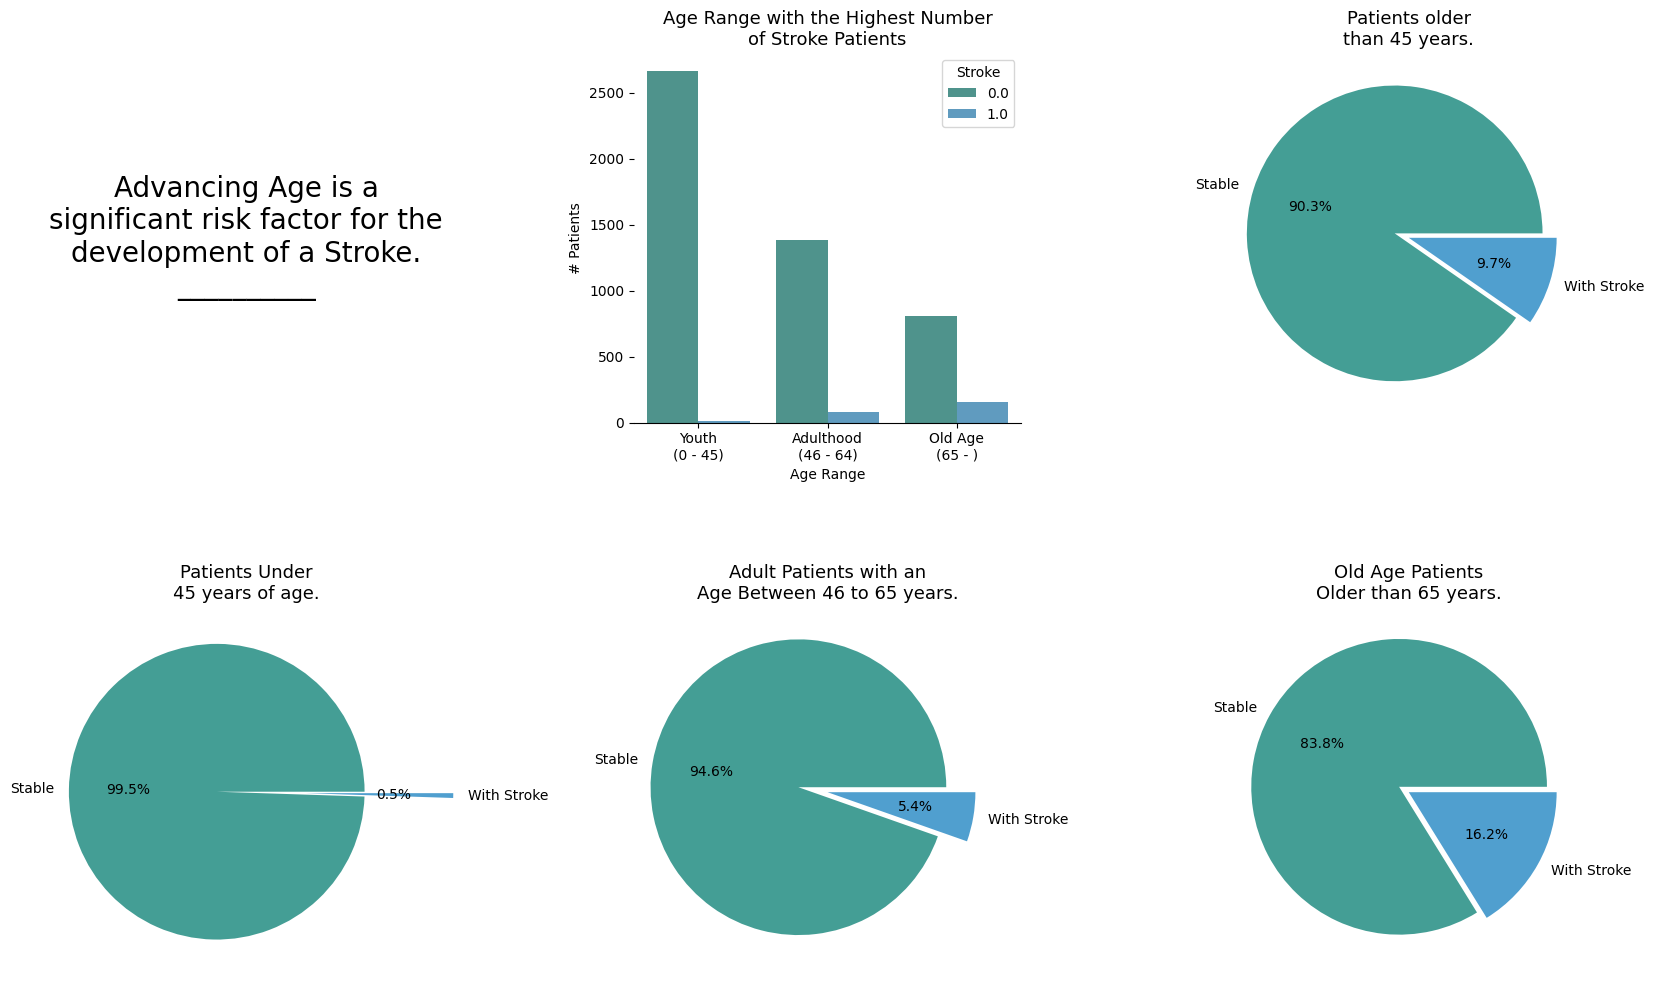

In [ ]:
# DF of patients categorized by age range.
df_eda['age_range'] = pd.cut(df_eda['age'], bins=[0, 46, 65, np.inf], include_lowest=True,
                             labels=["Youth\n(0 - 45)", "Adulthood\n(46 - 64)", "Old Age\n(65 - )"])

df_eda['old_age'] = pd.cut(df_eda['age'], bins=[0, 46, np.inf], include_lowest=True,
                             labels=["Youth", "Adulthood & Old Age"])

# Adulthood & Old Age.
adul_old = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age") & (df_eda['stroke'] == 0)])
adul_old_stroke = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age") & (df_eda['stroke'] == 1)])
adul_old_total = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age")])
adul_old = round((adul_old / adul_old_total) * 100, 2)
adul_old_stroke = round((adul_old_stroke / adul_old_total) * 100, 2)
patients_adul_old = [adul_old, adul_old_stroke]

# Youth.
youth = len(df_eda.loc[(df_eda['age_range'] == "Youth\n(0 - 45)") & (df_eda['stroke'] == 0)])
youth_stroke = len(df_eda.loc[(df_eda['age_range'] == "Youth\n(0 - 45)") & (df_eda['stroke'] == 1)])
youth_total = len(df_eda.loc[(df_eda['age_range'] == "Youth\n(0 - 45)")])
youth = round((youth / youth_total) * 100, 2)
youth_stroke = round((youth_stroke / youth_total) * 100, 2)
patients_youth = [youth, youth_stroke]

# Adulthood.
adul = len(df_eda.loc[(df_eda['age_range'] == "Adulthood\n(46 - 64)") & (df_eda['stroke'] == 0)])
adul_stroke = len(df_eda.loc[(df_eda['age_range'] == "Adulthood\n(46 - 64)") & (df_eda['stroke'] == 1)])
adul_total = len(df_eda.loc[(df_eda['age_range'] == "Adulthood\n(46 - 64)")])
adul = round((adul / adul_total) * 100, 2)
adul_stroke = round((adul_stroke / adul_total) * 100, 2)
patients_adul = [adul, adul_stroke]

# Old Age.
old = len(df_eda.loc[(df_eda['age_range'] == "Old Age\n(65 - )") & (df_eda['stroke'] == 0)])
old_stroke = len(df_eda.loc[(df_eda['age_range'] == "Old Age\n(65 - )") & (df_eda['stroke'] == 1)])
old_total = len(df_eda.loc[(df_eda['age_range'] == "Old Age\n(65 - )")])
old = round((old / old_total) * 100, 2)
old_stroke = round((old_stroke / old_total) * 100, 2)
patients_old = [old, old_stroke]
# Define color palette
palette = ['#449E95', '#509FCF']

# Create Figure and Gridspec
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.5, hspace=0.5)

# Title Plot
ax0 = fig.add_subplot(gs[0, 0])
ax0.text(0.5, 0.5, 'Advancing Age is a\nsignificant risk factor for the\ndevelopment of a Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Countplot for Age Range
ax1 = fig.add_subplot(gs[0, 1])
sns.countplot(x='age_range', hue='stroke', data=df_eda, palette=palette, ax=ax1)
ax1.set_title(f"Age Range with the Highest Number\nof Stroke Patients", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('Age Range')
ax1.set_ylabel('# Patients')

# Pie Chart for Adulthood & Old Age
ax2 = fig.add_subplot(gs[0, 2])
ax2.pie(patients_adul_old, labels=['Stable', 'With Stroke'], autopct='%1.1f%%',
        explode=[0.1, 0], colors=['#449E95', '#509FCF'])
ax2.set_title("Patients older\nthan 45 years.", fontsize=13)

# Pie Chart for Youth
ax3 = fig.add_subplot(gs[1, 0])
ax3.pie(patients_youth, labels=['Stable', 'With Stroke'], autopct='%1.1f%%',
        explode=[0.2, 0.4], colors=['#449E95', '#509FCF'])
ax3.set_title("Patients Under\n45 years of age.", fontsize=13)

# Pie Chart for Adulthood
ax4 = fig.add_subplot(gs[1, 1])
ax4.pie(patients_adul, labels=['Stable', 'With Stroke'], autopct='%1.1f%%',
        explode=[0.2, 0], colors=['#449E95', '#509FCF'])
ax4.set_title("Adult Patients with an\nAge Between 46 to 65 years.", fontsize=13)

# Pie Chart for Old Age
ax5 = fig.add_subplot(gs[1, 2])
ax5.pie(patients_old, labels=['Stable', 'With Stroke'], autopct='%1.1f%%',
        explode=[0.075, 0], colors=['#449E95', '#509FCF'])
ax5.set_title("Old Age Patients\nOlder than 65 years.", fontsize=13)

plt.show()



* Observations. </H4>
 * There is a positive trend of patients who have had a Stroke according to their age.
   * 9.7% patients older than 45 have suffered a Storke. </p>
   * Patients over 65 are the population of age more stroke cases with 16.2%. </
   * 5.4% of patients between 46 and 65 years have had a Stroke.
   *  Only 0.5% of patients under 45 have had a Stroke.
   



---



### Patients with an Advanced Age and with a BMI have a higher risk of having Stroke.

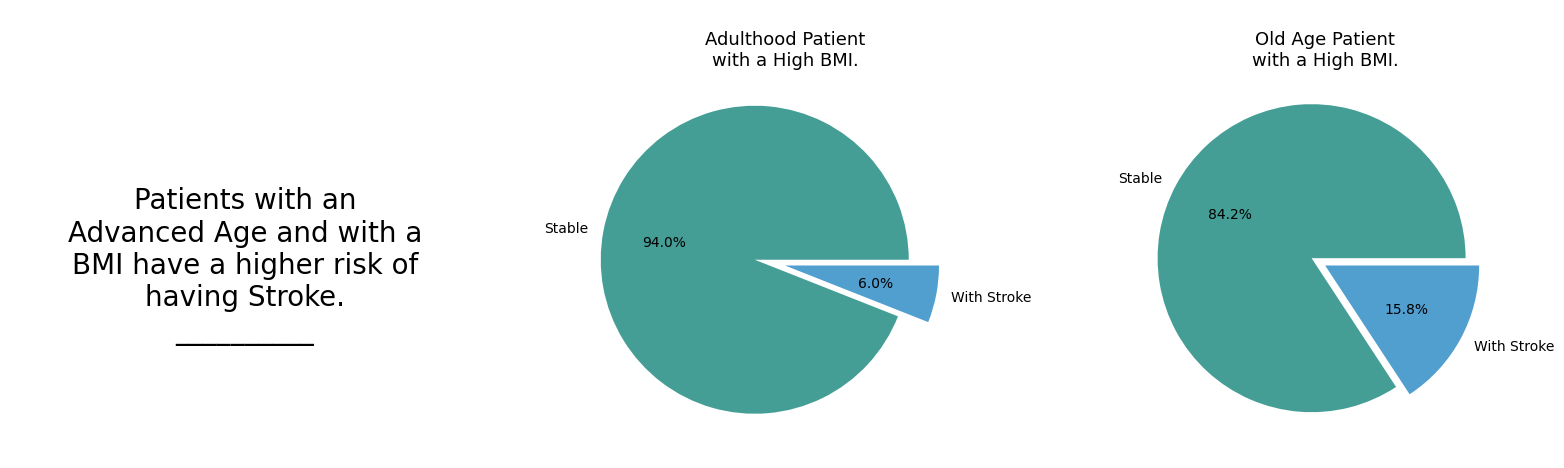

In [ ]:
# DF of Patients categorized by their high BMI
df_eda['high BMI'] = pd.cut(df_eda['bmi'], bins=[0, 18.5, 24.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "High BMI"])

# Adulthood.
adul_h_AgeBMI = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
adul_h_AgeBMI_stroke = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
adul_h_AgeBMI_total = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI')])
adul_h_AgeBMI = round((adul_h_AgeBMI / adul_h_AgeBMI_total) * 100, 2)
adul_h_AgeBMI_stroke = round((adul_h_AgeBMI_stroke / adul_h_AgeBMI_total) * 100, 2)
pacients_adul_h_AgeBMI_total = [adul_h_AgeBMI, adul_h_AgeBMI_stroke]

# Old Age.
old_h_AgeBMI = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
old_h_AgeBMI_stroke = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
old_h_AgeBMI_total = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI')])
old_h_AgeBMI = round((old_h_AgeBMI / old_h_AgeBMI_total) * 100, 2)
old_h_AgeBMI_stroke = round((old_h_AgeBMI_stroke / old_h_AgeBMI_total) * 100, 2)
pacients_old_h_AgeBMI = [old_h_AgeBMI, old_h_AgeBMI_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with an\nAdvanced Age and with a\nBMI have a higher risk of\nhaving Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Adulthood.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(pacients_adul_h_AgeBMI_total, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nAdulthood Patient\nwith a High BMI.", fontsize=13)

# Plot Old.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(pacients_old_h_AgeBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nOld Age Patient\nwith a High BMI.", fontsize=13)

plt.show()


* Observations.
  * 5.2% of patients at an age between 46 and 65 have had a Stroke.
  * Patients over 65 have had 13.9% of stroke cases.
  * Most of the "adulthouse" and "Old Age" patients have a high BMI (complement with graph at point 4.1.1).
  

### Smokers with a high BMI have a higher risk of having a Stroke.

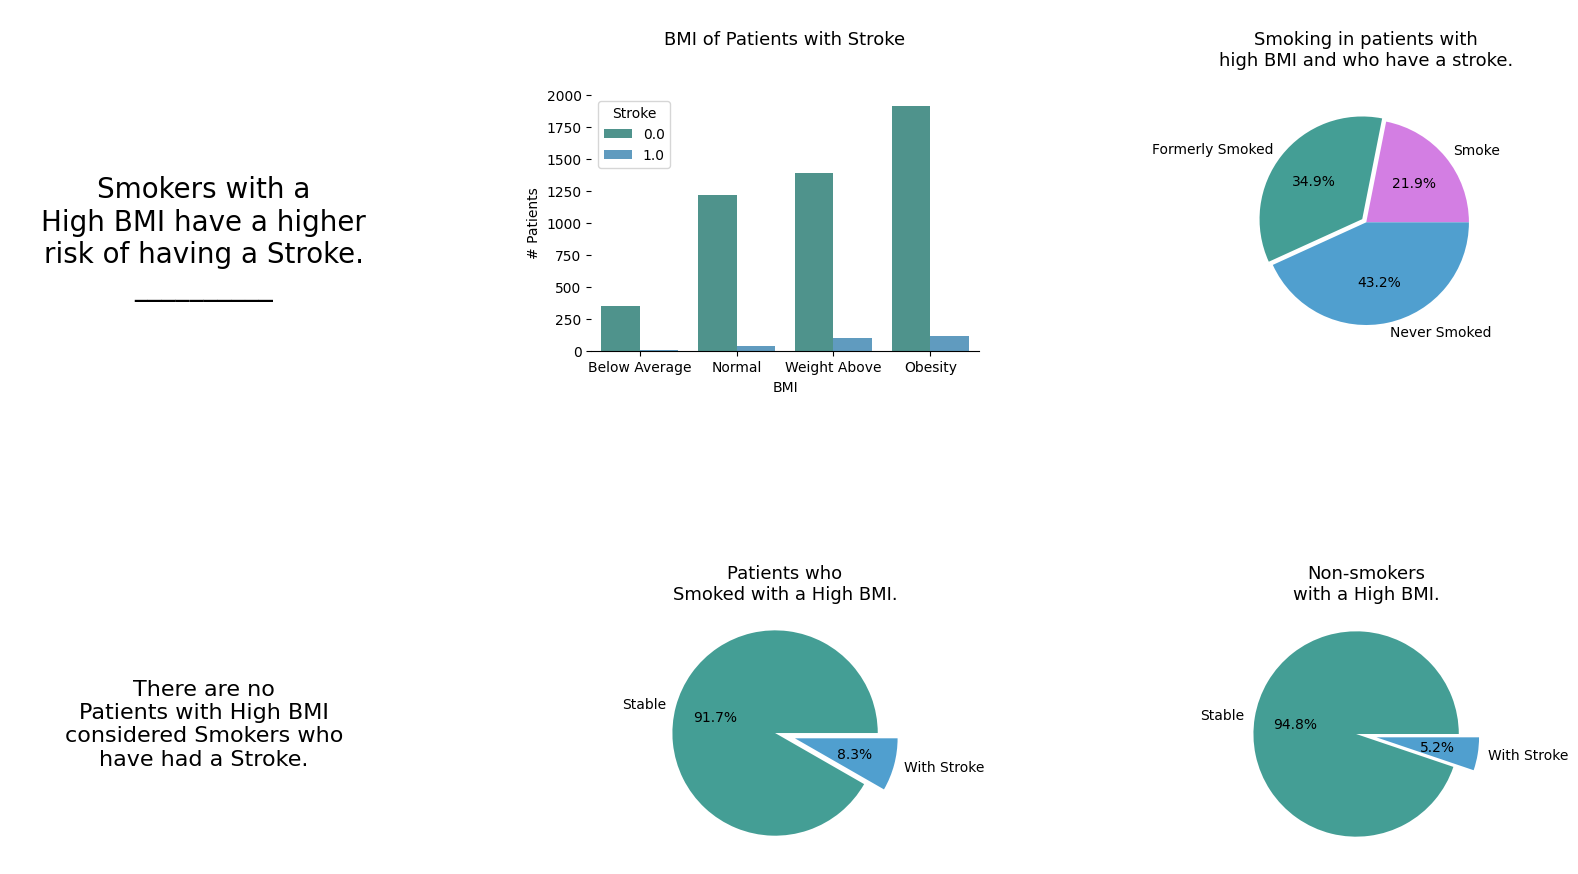

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color palette
palette = ['#449E95', '#509FCF']

# Example data for df_eda (replace with your actual data loading method)
# Assuming df_eda is already loaded and contains columns: 'bmi', 'smoking_status', 'stroke', etc.

# Categorize BMI
df_eda['bmi_cat'] = pd.cut(df_eda['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "Weight Above", "Obesity"])

# Define 'High BMI' for simplification
df_eda['high BMI'] = np.where(df_eda['bmi'] > 25, 'High BMI', 'Normal BMI')

# Smokers with High BMI who had a stroke
smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'smokes') &
                                   (df_eda['high BMI'] == 'High BMI') &
                                   (df_eda['stroke'] == 1)])

# Formerly smoked with High BMI and stroke
f_smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') &
                                     (df_eda['high BMI'] == 'High BMI') &
                                     (df_eda['stroke'] == 1)])

# Never smoked with High BMI and stroke
no_smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') &
                                      (df_eda['high BMI'] == 'High BMI') &
                                      (df_eda['stroke'] == 1)])

# Formerly smoked data for pie chart
f_smokes = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') &
                          (df_eda['high BMI'] == 'High BMI') &
                          (df_eda['stroke'] == 0)])
f_smokes_total = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') &
                                (df_eda['high BMI'] == 'High BMI')])
f_smokes_stroke = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') &
                                 (df_eda['high BMI'] == 'High BMI') &
                                 (df_eda['stroke'] == 1)])
f_smokes = round((f_smokes / f_smokes_total) * 100, 2)
f_smokes_stroke = round((f_smokes_stroke / f_smokes_total) * 100, 2)
f_smoke_highBMI = [f_smokes, f_smokes_stroke]

# Never smoked data for pie chart
no_smokes = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') &
                           (df_eda['high BMI'] == 'High BMI') &
                           (df_eda['stroke'] == 0)])
no_smokes_total = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') &
                                 (df_eda['high BMI'] == 'High BMI')])
no_smokes_stroke = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') &
                                  (df_eda['high BMI'] == 'High BMI') &
                                  (df_eda['stroke'] == 1)])
no_smoke = round((no_smokes / no_smokes_total) * 100, 2)
no_smokes_stroke = round((no_smokes_stroke / no_smokes_total) * 100, 2)
no_smoke_highBMI = [no_smoke, no_smokes_stroke]

# Create figure and gridspec layout
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.5, hspace=1)

# Title plot for High BMI
ax0 = fig.add_subplot(gs[0, 0])
ax0.text(0.5, 0.5, '\nSmokers with a\nHigh BMI have a higher\nrisk of having a Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Countplot for BMI categories
ax1 = fig.add_subplot(gs[0, 1])
sns.countplot(x='bmi_cat', hue='stroke', data=df_eda, palette=palette, ax=ax1)
ax1.set_title(f"BMI of Patients with Stroke\n\n", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('BMI')
ax1.set_ylabel('# Patients')

# Pie chart for smoking status and high BMI
ax2 = fig.add_subplot(gs[0, 2])
ax2.pie([smokes_stroke_len, f_smokes_stroke_len, no_smokes_stroke_len], autopct='%1.1f%%', explode=[0, 0.05, 0],
        labels=['Smoke', 'Formerly Smoked', 'Never Smoked'], colors=['#D37EE3', '#449E95', '#509FCF'])
ax2.set_title("\nSmoking in patients with\nhigh BMI and who have a stroke.\n", fontsize=13)

# Title plot for smokers
ax3 = fig.add_subplot(gs[1, 0])
ax3.text(0.5, 0.5, 'There are no\nPatients with High BMI\nconsidered Smokers who\nhave had a Stroke.\n',
         fontsize=16, horizontalalignment='center', verticalalignment='center')
ax3.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax3.tick_params(left=False, bottom=False)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Pie chart for formerly smoked
ax4 = fig.add_subplot(gs[1, 1])
ax4.pie(f_smoke_highBMI, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors=['#449E95', '#509FCF'])
ax4.set_title("Patients who\nSmoked with a High BMI.", fontsize=13)

# Pie chart for non-smokers
ax5 = fig.add_subplot(gs[1, 2])
ax5.pie(no_smoke_highBMI, labels=['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors=['#449E95', '#509FCF'])
ax5.set_title("Non-smokers\nwith a High BMI.", fontsize=13)

plt.show()


* Observations.
  * There is a positive trend of patients who have had a Stroke as they have a high BMI.
  * There are no data from patients who smoke, have a high BMI and have a Stroke.
  * The patients who smoked and who have a high BMI, 7% have had a Stroke.
  * The patients who have never smoked but have a high BMI 5% have had a Stroke.
  * The percentage of patients with Stroke with a high BMI between those who smoked and those who did not smoke is very similar.

### Patients with Hypertension and Heart Disease are more likely to have a Stroke compared to those without these conditions.

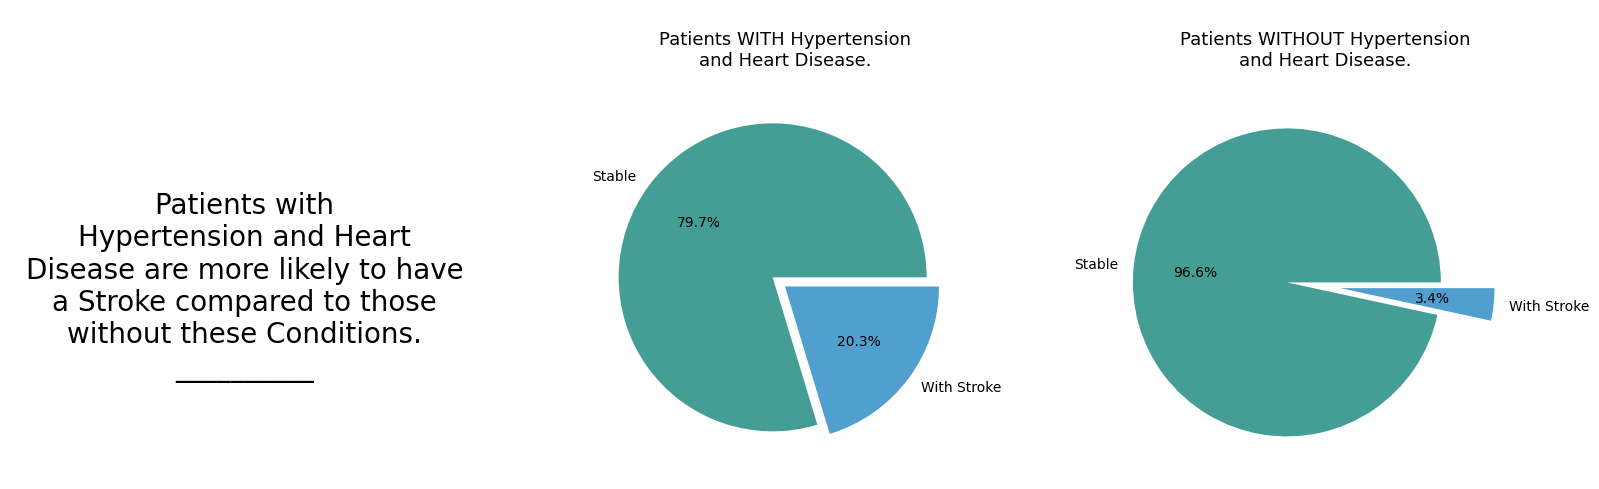

In [ ]:
# With.
with_hh = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1) & (df_eda['stroke'] == 0)])
with_hh_stroke = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1) & (df_eda['stroke'] == 1)])
with_hh_total = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1)])
with_hh = round((with_hh / with_hh_total) * 100, 2)
with_hh_stroke = round((with_hh_stroke / with_hh_total) * 100, 2)
patients_with_hh = [with_hh, with_hh_stroke]

# Without.
without_hh = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0) & (df_eda['stroke'] == 0)])
without_hh_stroke = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0) & (df_eda['stroke'] == 1)])
without_hh_total = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0)])
without_hh = round((without_hh / without_hh_total) * 100, 2)
without_hh_stroke = round((without_hh_stroke / without_hh_total) * 100, 2)
patients_without_hh = [without_hh, without_hh_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with\nHypertension and Heart\nDisease are more likely to have\na Stroke compared to those\nwithout these Conditions.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot With.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_with_hh, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients WITH Hypertension\nand Heart Disease.\n", fontsize=13)

# Plot Without.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_without_hh, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.25, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients WITHOUT Hypertension\nand Heart Disease.\n", fontsize=13)

plt.show()


* Observations
  * 20.3% of patients with Hypertension and Heart Diseasew have had a Stroke.
  * The patients without hypertension and Heart Disease 3.4% have not had a Stroke.
  * Patients who have love conditions have 6 times more likely to have a Stroke.


### Patients with elevated Blood Glucose levels have a higher risk of suffering a Stroke compared to those with Normal Glucose Levels.

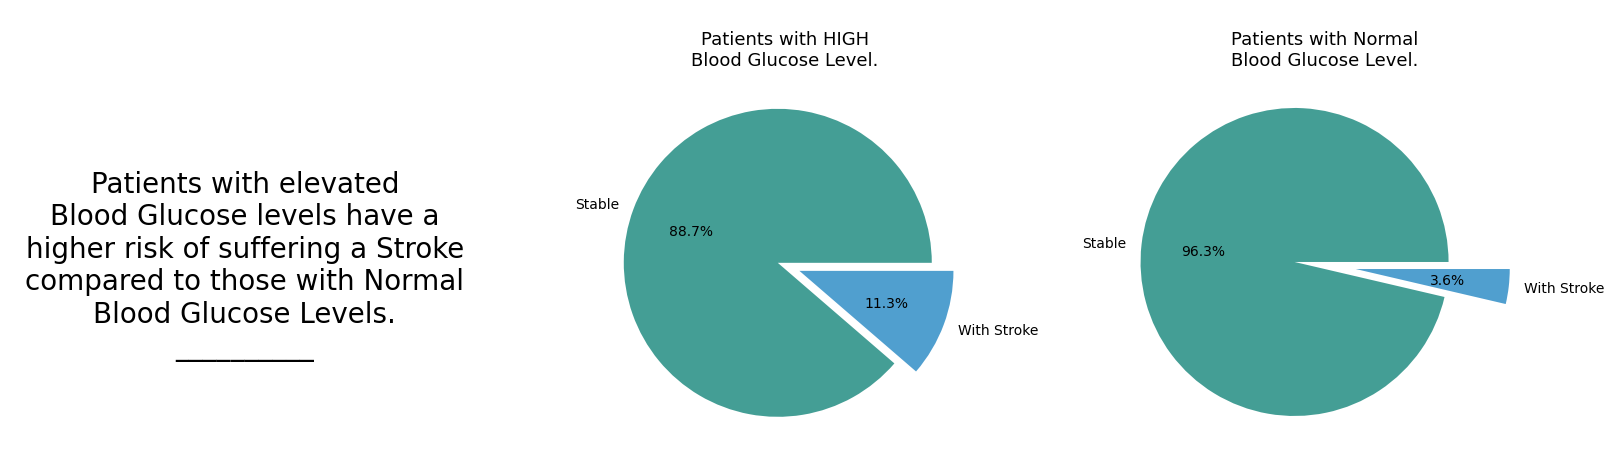

In [ ]:
df_eda['avg_gluc_lvl_range'] = pd.cut(df_eda['avg_glucose_level'], bins=[0, 70, 140, np.inf], include_lowest=True,
                                          labels=["Low Level", "Normal Level", "High Level"])

# High.
high = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level') & (df_eda['stroke'] == 0)])
high_stroke =  len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level') & (df_eda['stroke'] == 1)])
high_total = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level')])
high = round((high / high_total) * 100, 2)
high_stroke = round((high_stroke / high_total) * 100, 2)
patients_high = [high, high_stroke]

# Normal.
normal = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Normal Level') & (df_eda['stroke'] == 0)])
normal_stroke = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Normal Level') & (df_eda['stroke'] == 1)])
normal_total = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Normal Level')])
normal = round((normal / normal_total) * 100, 2)
normal_stroke = round((normal_stroke / normal_total) * 100, 2)
patients_normal = [normal, normal_stroke]

# Plot.
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title.
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with elevated\nBlood Glucose levels have a\nhigher risk of suffering a Stroke\ncompared to those with Normal\nBlood Glucose Levels.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_high, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.05, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients with HIGH\nBlood Glucose Level.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_normal, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.2], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients with Normal\nBlood Glucose Level.", fontsize=13)

plt.show()

* Observation
  * 11.3% of patients with high glucose level have had a Stroke
  * Of the patients who have a normal level of glucose only 3.6% have had a Stroke.
  * Patients with a high glucose level have 3 times more likely to have a Stroke.


### Patients who live in Urban Areas are at Higher risk of having a Stroke than those who live in Rural Areas.

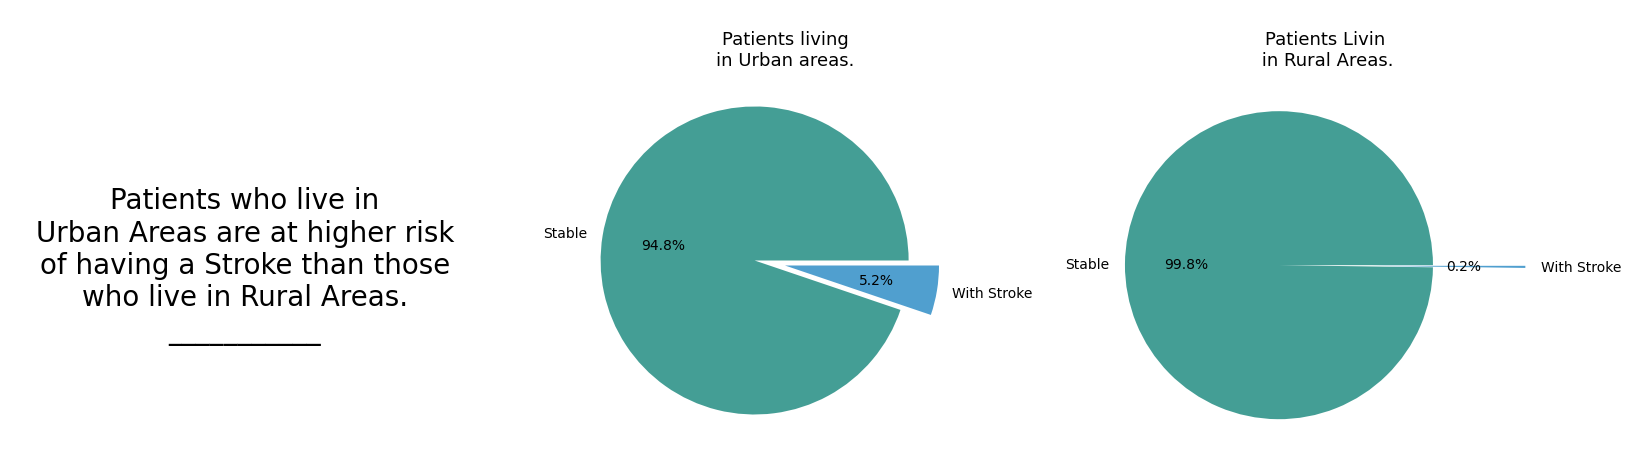

In [ ]:
# Urban
urban = len(df_eda.loc[(df_eda['Residence_type'] == 'Urban') & (df_eda['stroke'] == 0)])
urban_stroke =  len(df_eda.loc[(df_eda['Residence_type'] == 'Urban') & (df_eda['stroke'] == 1)])
urban_total = len(df_eda.loc[(df_eda['Residence_type'] == 'Urban')])
urban = round((urban / urban_total) * 100, 2)
urban_stroke = round((urban_stroke / urban_total) * 100, 2)
patients_urban = [urban, urban_stroke]

# Rural
rural = len(df_eda.loc[(df_eda['Residence_type'] == 'Rural') & (df_eda['stroke'] == 0)])
rural_stroke =  len(df_eda.loc[(df_eda['Residence_type'] == 'Rural') & (df_eda['stroke'] == 1)])
rural_total = len(df_eda.loc[(df_eda['Residence_type'] == 'Rural')])
rural = round((rural / rural_total) * 100, 2)
rural_stroke = round((urban_stroke / rural_total) * 100, 2)
patients_rural = [rural, rural_stroke]


# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients who live in\nUrban Areas are at higher risk\nof having a Stroke than those\nwho live in Rural Areas.\n___________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Urban.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_urban, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients living\nin Urban areas.", fontsize=13)

# Plot Rural.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_rural, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.3, 0.3], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients Livin\n in Rural Areas.", fontsize=13)

plt.show()

* Observations.</h4>
  Of the people living in urban areas 5.2% have had a Stroke.</p>
  * 98.8% of people living in rural areas have not had a Stroke.</p>


### Married Men have an increased risk of having a Stroke than Married Women.

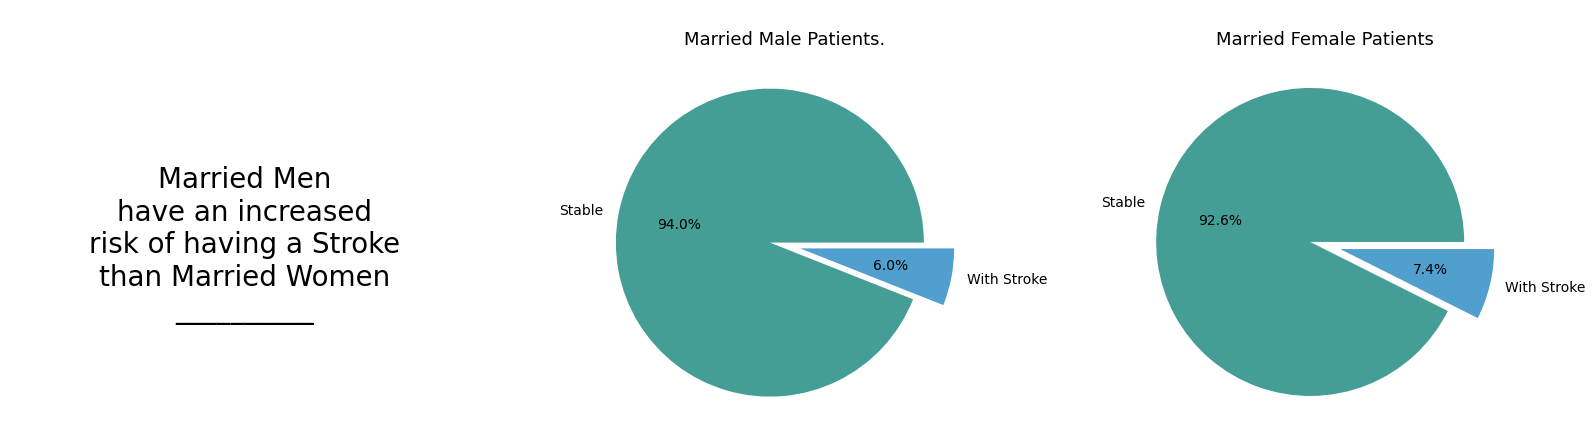

In [ ]:
# Female
female = len(df_eda.loc[(df_eda['gender'] == 'Female') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 0)])
female_stroke =  len(df_eda.loc[(df_eda['gender'] == 'Female') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 1)])
female_total = len(df_eda.loc[(df_eda['gender'] == 'Female') & (df_eda['ever_married'] == 'Yes')])
female = round((female / female_total) * 100, 2)
female_stroke = round((female_stroke / female_total) * 100, 2)
patients_female = [female, female_stroke]

# Male
male = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 0)])
male_stroke =  len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 1)])
male_total = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes')])
male = round((male / male_total) * 100, 2)
male_stroke = round((male_stroke / male_total) * 100, 2)
patients_male = [male, male_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Married Men\nhave an increased\nrisk of having a Stroke\nthan Married Women\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_female, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nMarried Male Patients.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_male, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nMarried Female Patients", fontsize=13)

plt.show()


* Observations.</h4>
  * Men who are married patients 6% have had a Stroke.
  * Women who are married 7.4% have had a Stroke.</p>
  

## Feature Selection Based on Correlation analysis and pvalue

In [ ]:
# Manually Specified Feature Selection Based on Correlation analysis and pvalue
selected_features = [
    "age",                # Strong correlations with multiple key variables
    "bmi",                # Moderately correlated with age and work type
    "hypertension",       # Correlated with age and smoking status
    "heart_disease",      # Correlated with age and smoking status
    "ever_married",       # Strong correlation with age and work type
    "work_type"           # Significant relationships with age, BMI, and marriage
]

# Target variable
target = "stroke"

# Subset the dataset with selected features
df_selected = df[selected_features + [target]]
df_selected = handle_missing_values(df_selected, method='knn')
print(f"Dataset with Selected Features:\n{df_selected.head()}")


Dataset with Selected Features:
    age    bmi  hypertension  heart_disease ever_married      work_type  \
0  67.0  36.60           0.0            1.0          Yes        Private   
1  61.0  33.92           0.0            0.0          Yes  Self-employed   
2  80.0  32.50           0.0            1.0          Yes        Private   
3  49.0  34.40           0.0            0.0          Yes        Private   
4  79.0  24.00           1.0            0.0          Yes  Self-employed   

   stroke  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0  


### Separate features and target

In [ ]:
X = df_selected.drop(columns=[target])
y = df_selected[target]

## Splitting the Dataset Train-Validation-Test Split

In [ ]:
# Step 1: Train (80%) and temp (20%) split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Validation (10%) and Test (10%) split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verify split sizes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Training set: (4088, 6), (4088,)
Validation set: (511, 6), (511,)
Test set: (511, 6), (511,)


Observation:
* The "KNNImputer" transformer is used to fill in the missing values "KNNImputer" is used to maintain greater fidelity in the data, since it obtains the mean value of the nearest patients.
* Data is split into training and temp(test,validation).
* To ensure the robustness and effectiveness of the model, only validation data was used for model tuning. The validation set evaluates the model's performance during training and helps in hyperparameter tuning.
* The test set evaluates the final model performance after training and hyperparameter tuning.



### Handle Class Imbalance with SMOTENC

+---------------+-------+
| Stroke Status | Count |
+---------------+-------+
|      0.0      |  3889 |
|      1.0      |  3889 |
+---------------+-------+


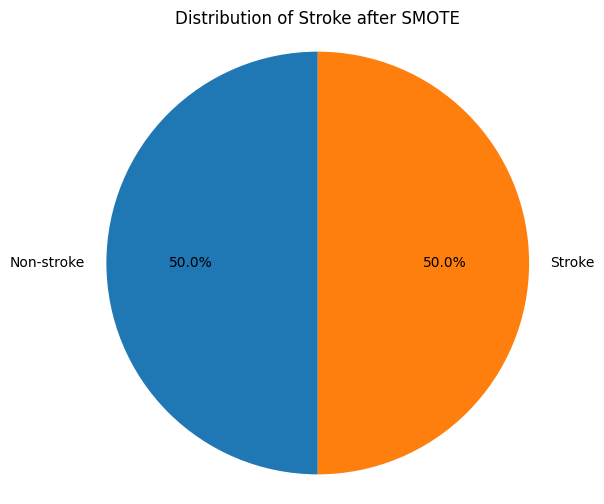

In [ ]:
from imblearn.over_sampling import SMOTENC
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

smotenc = SMOTENC(
    categorical_features=[X.columns.get_loc(col) for col in categorical_columns],
    random_state=42
)

# Resample the training data
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train, y_train)

# Convert SMOTENC output back to DataFrame
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)

# Validate categorical features and drop invalid rows
for col in categorical_columns:
    valid_categories = X_train[col].unique()
    invalid_rows = ~X_train_balanced[col].isin(valid_categories)
    if invalid_rows.any():
        print(f"Invalid categories detected in '{col}'. Dropping {invalid_rows.sum()} rows.")
        X_train_balanced = X_train_balanced[~invalid_rows]
        y_train_balanced = y_train_balanced[~invalid_rows]

# Verify class distribution
table = PrettyTable()
table.field_names = ["Stroke Status", "Count"]
for status, count in y_train_balanced.value_counts().items():
    table.add_row([status, count])
print(table)

# Pie chart for class distribution
plt.figure(figsize=(6, 6))
plt.pie(y_train_balanced.value_counts(), labels=['Non-stroke', 'Stroke'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Stroke after SMOTE')
plt.axis('equal')
plt.show()


Observations.
* The fact that the data is not balanced affects the algorithms in their information generalization processes and harms the minority class.

* Without a correct balance, the model will not be able to differentiate one class from another.

* The model would have a class bias with more examples.
* SMOTENC is used to balance the data.

* the validation and test sets remain unbalanced (in their original state). This is essential because:
* The validation set evaluates the model's performance during training and helps in hyperparameter tuning.
* The test set evaluates the final model performance after training and hyperparameter tuning.

### Compare the cardinality of categorical features

In [ ]:
# Compare the cardinality of categorical features
print("\nCardinality Comparison Before and After Balancing:")
for col in categorical_columns:
    original_cardinality = X_train[col].nunique()
    balanced_cardinality = pd.DataFrame(X_train_balanced)[col].nunique()  # Convert to DataFrame for SMOTENC output
    print(f"Feature: {col}")
    print(f"- Original Training Data: {original_cardinality}")
    print(f"- Balanced Training Data: {balanced_cardinality}")

    # Optional: Raise a warning if cardinality changes unexpectedly
    if original_cardinality != balanced_cardinality:
        print(f"Warning: Cardinality changed for {col}!")



Cardinality Comparison Before and After Balancing:
Feature: ever_married
- Original Training Data: 2
- Balanced Training Data: 2
Feature: work_type
- Original Training Data: 5
- Balanced Training Data: 5


## Data Preprocessing  for Model.

In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

## Encoding Categorical Features

In [ ]:
# Identify categorical and numerical features in the dataset
categorical_features = X_train_balanced.select_dtypes(include=['object']).columns
numerical_features = X_train_balanced.select_dtypes(exclude=['object']).columns

# Create ColumnTransformer to apply One-Hot Encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Keep numerical features as-is
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-Hot Encoding for categorical features
    ]
)

# Apply the preprocessing to training, validation, and test data
X_train_encoded = preprocessor.fit_transform(X_train_balanced)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

Observations.
* The DF created for the model is used, the feature ID is removed and the categorical features are encoded. The same steps we used for the analysis.

* The "KNNImputer" transformer is used to fill in the missing values.

* "KNNImputer" is used to maintain greater fidelity in the data, since it obtains the mean value of the nearest patients.


### Scaling Numerical Features

In [ ]:
# Apply RobustScaler to scale numerical features in the training, validation, and test sets
scaler = RobustScaler()

X_train_scaled = X_train_encoded.copy()  # Copy encoded data
X_val_scaled = X_val_encoded.copy()
X_test_scaled = X_test_encoded.copy()

# Apply scaling to the numerical columns in the training, validation, and test sets
X_train_scaled[:, :len(numerical_features)] = scaler.fit_transform(X_train_encoded[:, :len(numerical_features)])
X_val_scaled[:, :len(numerical_features)] = scaler.transform(X_val_encoded[:, :len(numerical_features)])
X_test_scaled[:, :len(numerical_features)] = scaler.transform(X_test_encoded[:, :len(numerical_features)])

print("Preprocessing completed.")

Preprocessing completed.


Observation:
*  RobustScaler is use to scale the numerical columns.It is decided to use the Robust Scaler transformer due to the use of the "Interquartile Range" so that the model is not affected by the outliers.
* Scaling (Only for Logistic Regression and SVM)
* Logistic Regression and SVM benefit from scaling.
* Random Forest and Decision Tree do not require scaling.



# Model Building

##Model Training

### Base models an Evaluation


=== Logistic Regression - Base Model Evaluation ===

Evaluating Logistic Regression
Precision (No Stroke): 0.99
Recall (Stroke): 0.84
Confusion Matrix:
 [[353 133]
 [  4  21]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.73      0.84       486
         1.0       0.14      0.84      0.23        25

    accuracy                           0.73       511
   macro avg       0.56      0.78      0.54       511
weighted avg       0.95      0.73      0.81       511



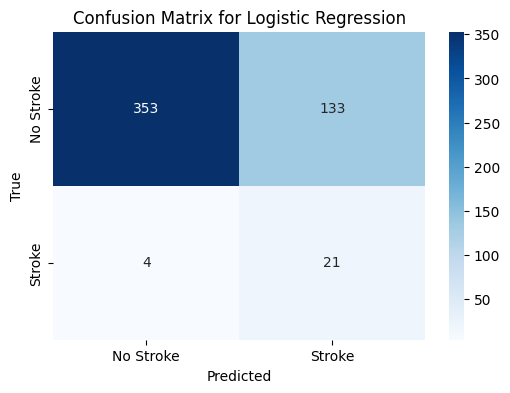

ROC AUC: 0.87


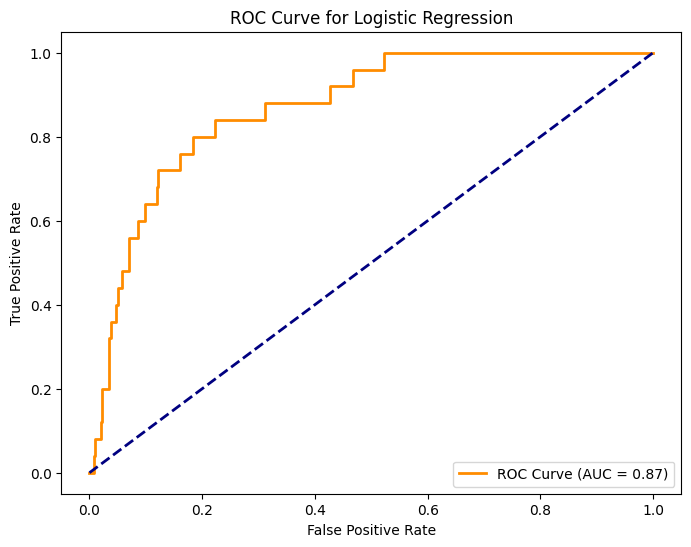


=== SVM - Base Model Evaluation ===

Evaluating SVM
Precision (No Stroke): 0.99
Recall (Stroke): 0.88
Confusion Matrix:
 [[362 124]
 [  3  22]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.74      0.85       486
         1.0       0.15      0.88      0.26        25

    accuracy                           0.75       511
   macro avg       0.57      0.81      0.55       511
weighted avg       0.95      0.75      0.82       511



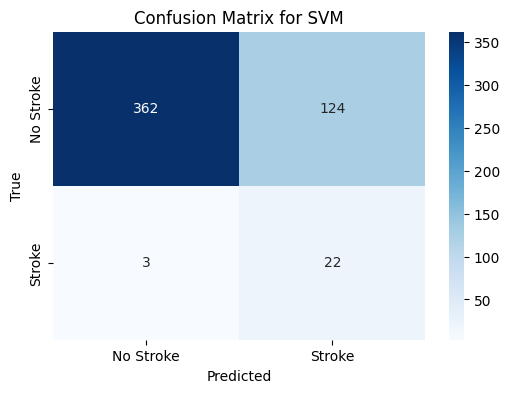

ROC AUC: 0.88


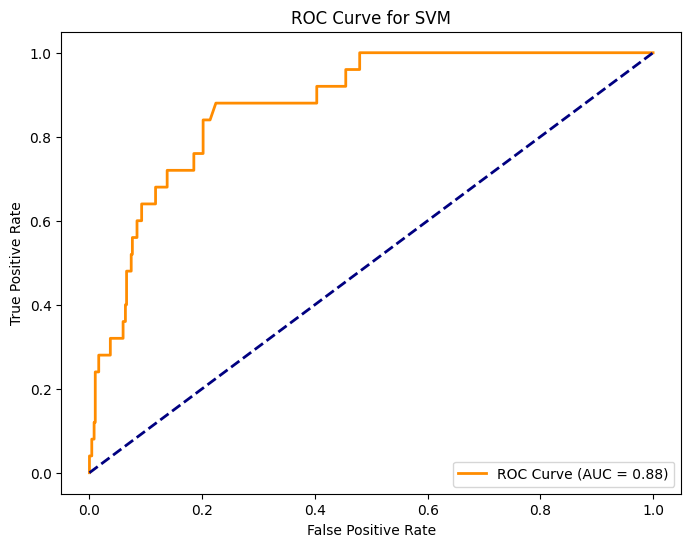


=== Random Forest - Base Model Evaluation ===

Evaluating Random Forest
Precision (No Stroke): 0.95
Recall (Stroke): 0.12
Confusion Matrix:
 [[458  28]
 [ 22   3]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       486
         1.0       0.10      0.12      0.11        25

    accuracy                           0.90       511
   macro avg       0.53      0.53      0.53       511
weighted avg       0.91      0.90      0.91       511



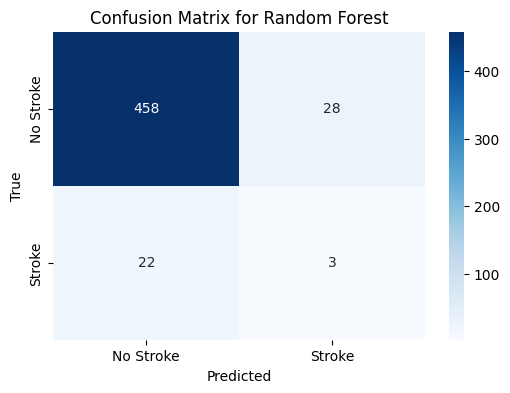

ROC AUC: 0.77


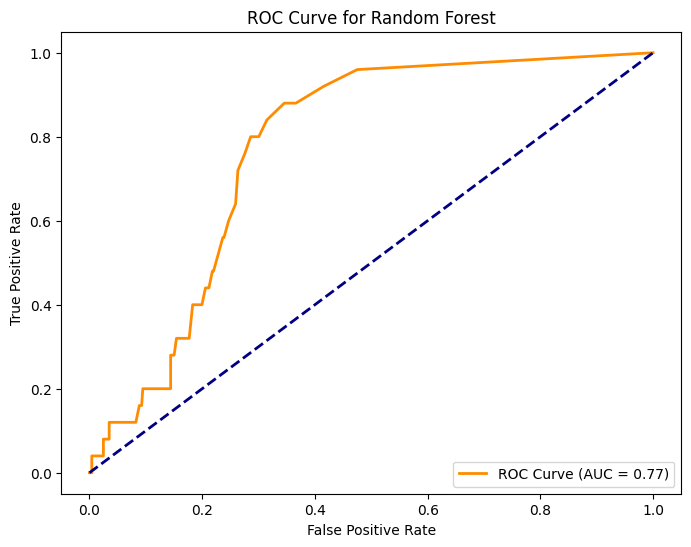


=== Decision Tree - Base Model Evaluation ===

Evaluating Decision Tree
Precision (No Stroke): 0.96
Recall (Stroke): 0.24
Confusion Matrix:
 [[448  38]
 [ 19   6]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       486
         1.0       0.14      0.24      0.17        25

    accuracy                           0.89       511
   macro avg       0.55      0.58      0.56       511
weighted avg       0.92      0.89      0.90       511



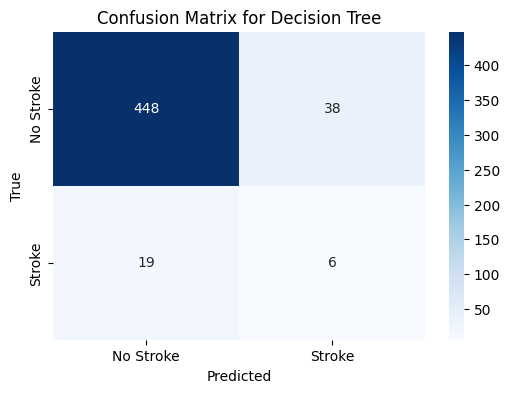

ROC AUC: 0.58


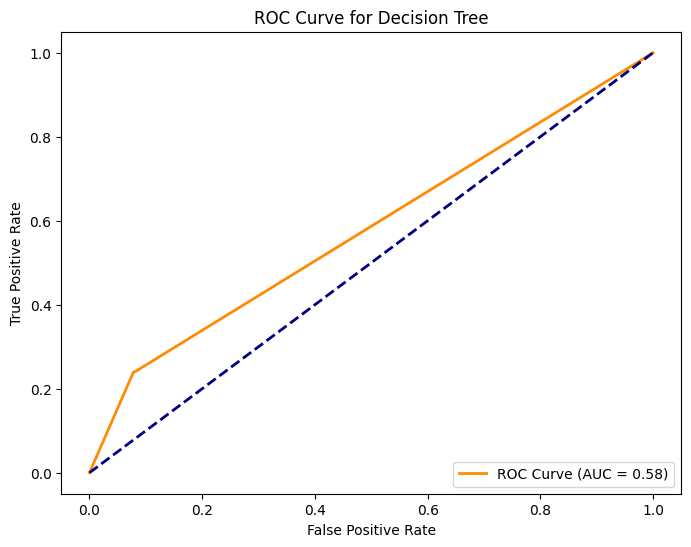

In [ ]:
# Step 1: Base Model and Evaluation

# Define models (without hyperparameter tuning)
logreg_model = LogisticRegression(random_state=42)
svm_model = SVC(random_state=42,probability=True)
rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Group the models with and without scaling
models_with_scaling = {
    "Logistic Regression": logreg_model,
    "SVM": svm_model
}

models_without_scaling = {
    "Random Forest": rf_model,
    "Decision Tree": dt_model
}

# Function to evaluate models and plot confusion matrix and AUC
def evaluate_model(model, X, y, model_name, is_scaled=True):
    print(f"\nEvaluating {model_name}")
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

    # Precision for class "No Stroke" (0) and Recall for class "Stroke" (1)
    precision_no_stroke = precision_score(y, y_pred, pos_label=0)  # Class 0: No Stroke
    recall_stroke = recall_score(y, y_pred, pos_label=1)  # Class 1: Stroke

    # Print Metrics
    print(f"Precision (No Stroke): {precision_no_stroke:.2f}")
    print(f"Recall (Stroke): {recall_stroke:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y, y_pred))

    # Plot Confusion Matrix with "No Stroke" and "Stroke" labels
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot ROC Curve and AUC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.2f}")

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()

# Train and evaluate base models
for name, model in models_with_scaling.items():
    print(f"\n=== {name} - Base Model Evaluation ===")
    model.fit(X_train_scaled, y_train_balanced)  # Train the model
    evaluate_model(model, X_val_scaled, y_val, name, is_scaled=True)  # Evaluate the model

for name, model in models_without_scaling.items():
    print(f"\n=== {name} - Base Model Evaluation ===")
    model.fit(X_train_encoded, y_train_balanced)  # Train the model
    evaluate_model(model, X_val_encoded, y_val, name, is_scaled=False)  # Evaluate the model


## Hyperparameter Tuning an Evaluation


=== Logistic Regression - Pre-Tuning Evaluation ===

Evaluating Logistic Regression
Precision (No Stroke): 0.99
Recall (Stroke): 0.84
Confusion Matrix:
 [[353 133]
 [  4  21]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.73      0.84       486
         1.0       0.14      0.84      0.23        25

    accuracy                           0.73       511
   macro avg       0.56      0.78      0.54       511
weighted avg       0.95      0.73      0.81       511



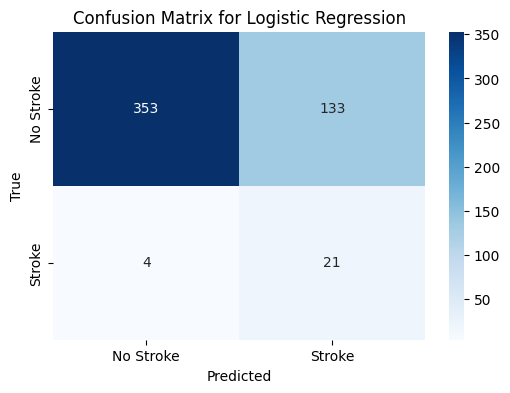

ROC AUC: 0.87


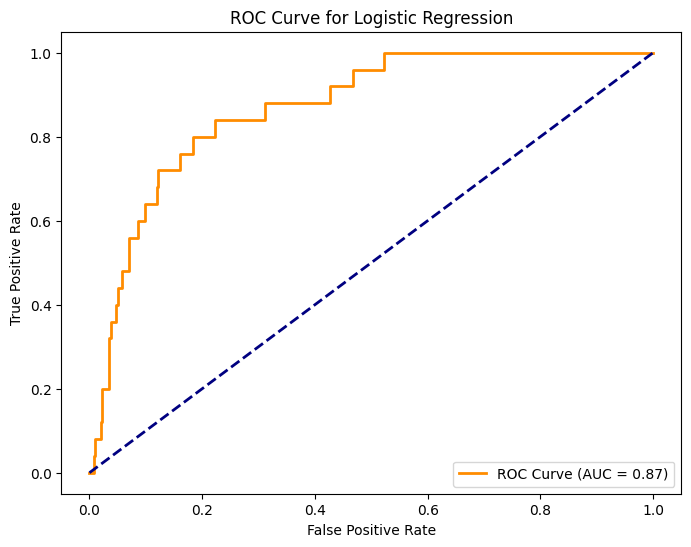


=== SVM - Pre-Tuning Evaluation ===

Evaluating SVM
Precision (No Stroke): 0.99
Recall (Stroke): 0.88
Confusion Matrix:
 [[362 124]
 [  3  22]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.74      0.85       486
         1.0       0.15      0.88      0.26        25

    accuracy                           0.75       511
   macro avg       0.57      0.81      0.55       511
weighted avg       0.95      0.75      0.82       511



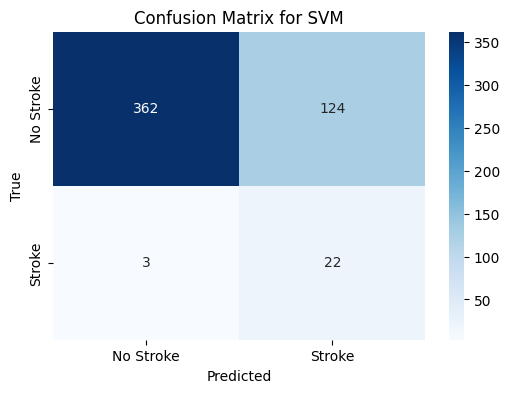

ROC AUC: 0.88


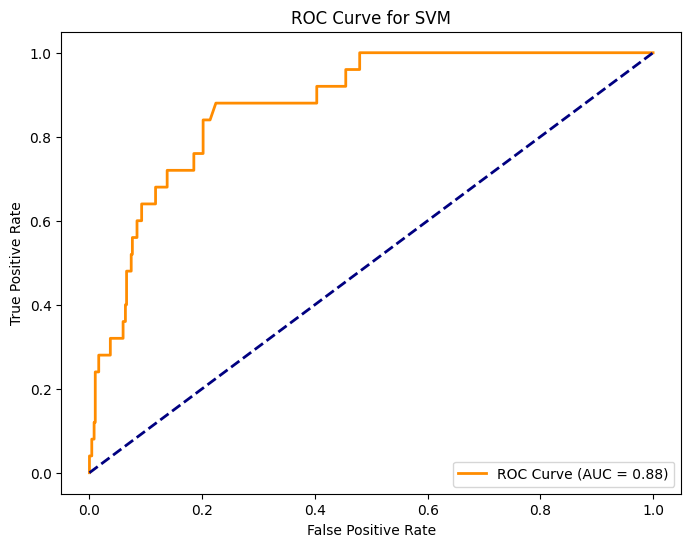


=== Random Forest - Pre-Tuning Evaluation ===

Evaluating Random Forest
Precision (No Stroke): 0.95
Recall (Stroke): 0.12
Confusion Matrix:
 [[458  28]
 [ 22   3]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       486
         1.0       0.10      0.12      0.11        25

    accuracy                           0.90       511
   macro avg       0.53      0.53      0.53       511
weighted avg       0.91      0.90      0.91       511



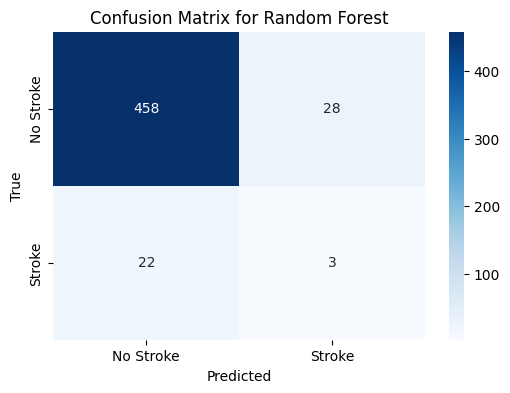

ROC AUC: 0.77


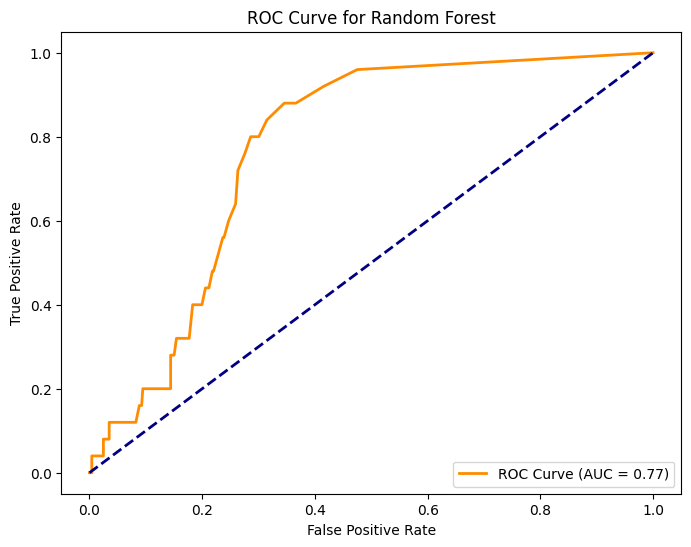


=== Decision Tree - Pre-Tuning Evaluation ===

Evaluating Decision Tree
Precision (No Stroke): 0.96
Recall (Stroke): 0.24
Confusion Matrix:
 [[448  38]
 [ 19   6]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       486
         1.0       0.14      0.24      0.17        25

    accuracy                           0.89       511
   macro avg       0.55      0.58      0.56       511
weighted avg       0.92      0.89      0.90       511



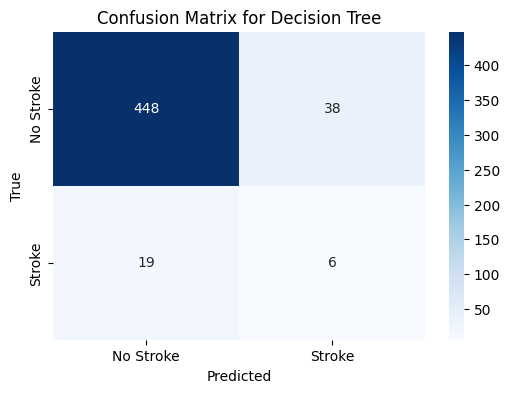

ROC AUC: 0.58


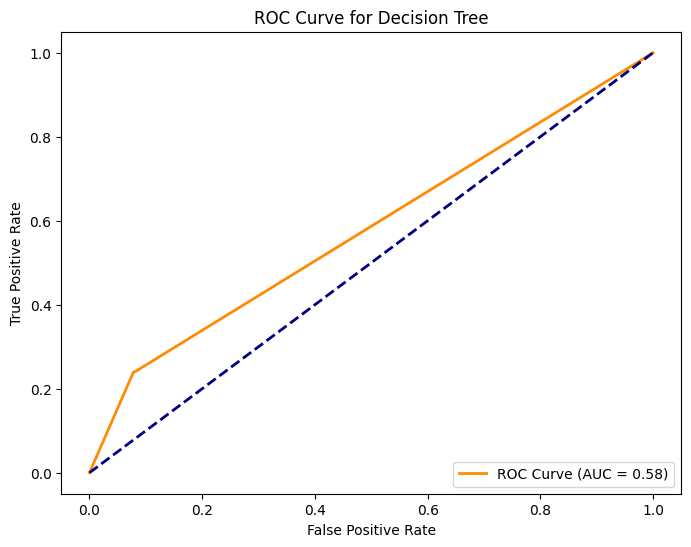


=== Logistic Regression - Hyperparameter Tuning ===
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}

Evaluating Logistic Regression
Precision (No Stroke): 0.99
Recall (Stroke): 0.88
Confusion Matrix:
 [[352 134]
 [  3  22]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.72      0.84       486
         1.0       0.14      0.88      0.24        25

    accuracy                           0.73       511
   macro avg       0.57      0.80      0.54       511
weighted avg       0.95      0.73      0.81       511



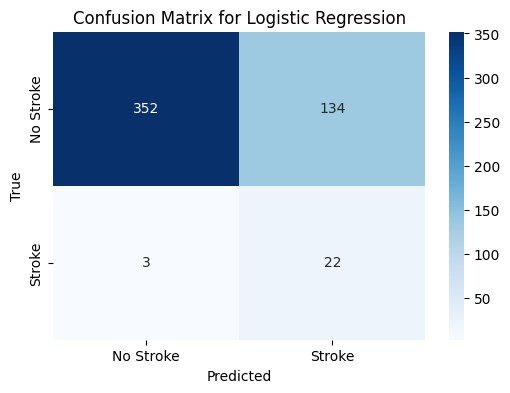

ROC AUC: 0.87


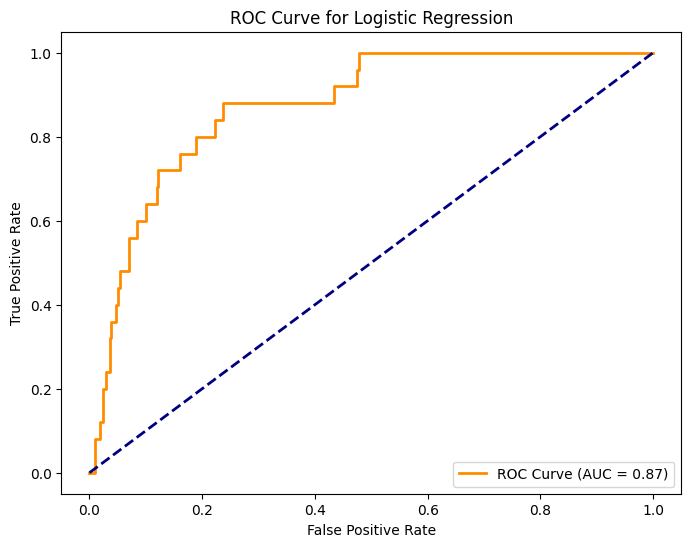


=== SVM - Hyperparameter Tuning ===
Best Parameters for SVM: {'C': 10, 'kernel': 'rbf'}

Evaluating SVM
Precision (No Stroke): 0.98
Recall (Stroke): 0.76
Confusion Matrix:
 [[363 123]
 [  6  19]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.75      0.85       486
         1.0       0.13      0.76      0.23        25

    accuracy                           0.75       511
   macro avg       0.56      0.75      0.54       511
weighted avg       0.94      0.75      0.82       511



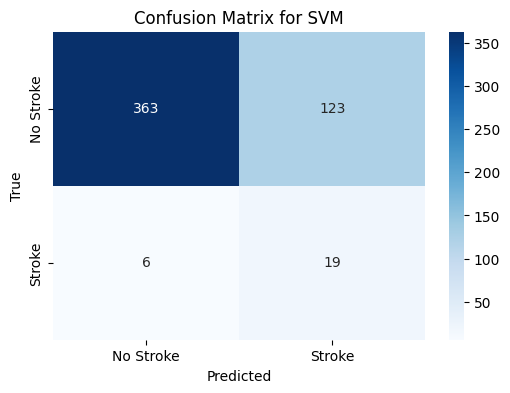

ROC AUC: 0.86


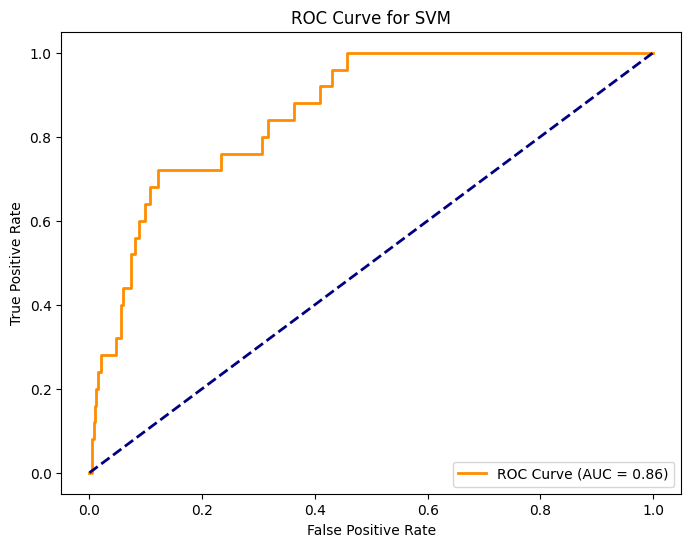


=== Random Forest - Hyperparameter Tuning ===
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Evaluating Random Forest
Precision (No Stroke): 0.95
Recall (Stroke): 0.12
Confusion Matrix:
 [[463  23]
 [ 22   3]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       486
         1.0       0.12      0.12      0.12        25

    accuracy                           0.91       511
   macro avg       0.54      0.54      0.54       511
weighted avg       0.91      0.91      0.91       511



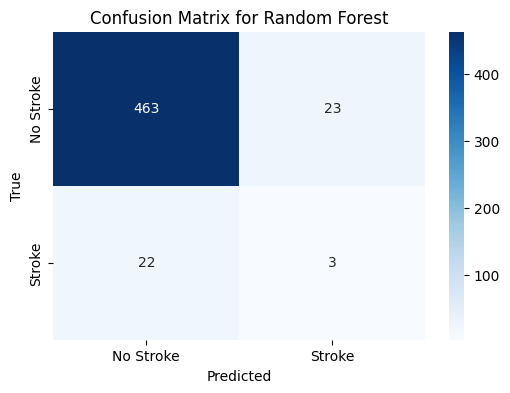

ROC AUC: 0.79


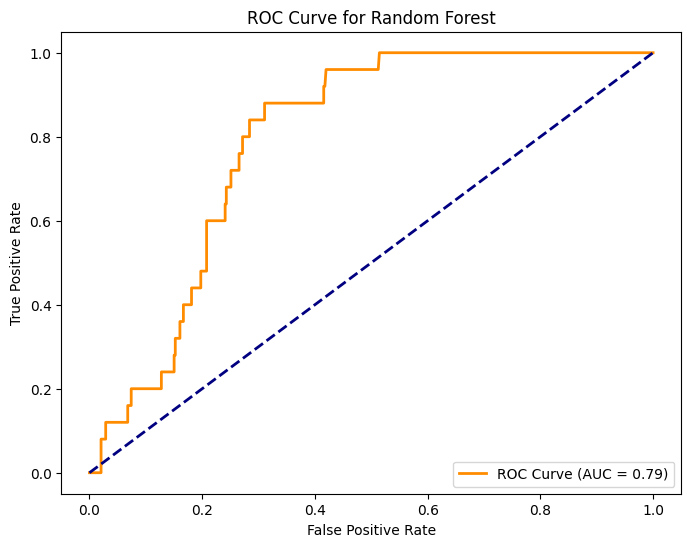


=== Decision Tree - Hyperparameter Tuning ===
Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 5}

Evaluating Decision Tree
Precision (No Stroke): 0.96
Recall (Stroke): 0.24
Confusion Matrix:
 [[453  33]
 [ 19   6]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       486
         1.0       0.15      0.24      0.19        25

    accuracy                           0.90       511
   macro avg       0.56      0.59      0.57       511
weighted avg       0.92      0.90      0.91       511



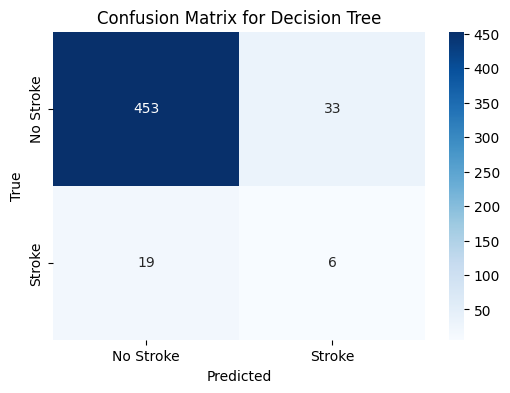

ROC AUC: 0.58


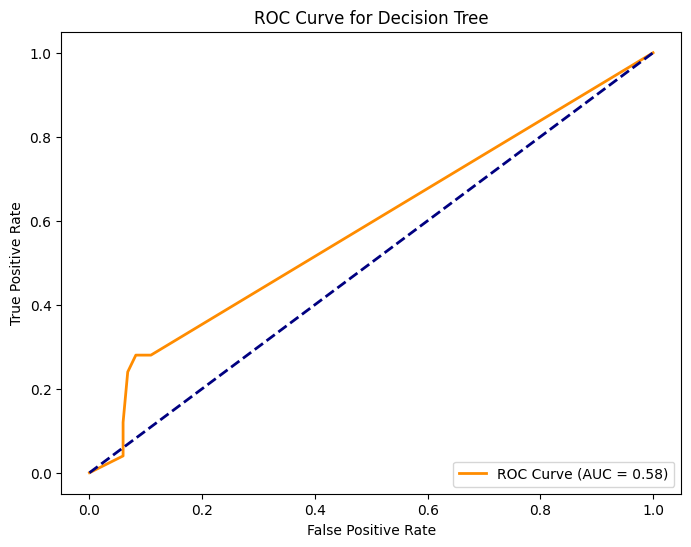

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Function to evaluate models and plot confusion matrix and AUC
def evaluate_model(model, X_val, y_val, model_name, is_scaled=True):
    print(f"\nEvaluating {model_name}")

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    # Precision for class "No Stroke" (0) and Recall for class "Stroke" (1)
    precision_no_stroke = precision_score(y_val, y_pred, pos_label=0)  # Class 0: No Stroke
    recall_stroke = recall_score(y_val, y_pred, pos_label=1)  # Class 1: Stroke

    # Print Metrics
    print(f"Precision (No Stroke): {precision_no_stroke:.2f}")
    print(f"Recall (Stroke): {recall_stroke:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_val, y_pred))

    # Plot Confusion Matrix with "No Stroke" and "Stroke" labels
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot ROC Curve and AUC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.2f}")

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()

# Define hyperparameters for each model
tuned_params = {
    "Logistic Regression": {
        "solver": ["lbfgs", "liblinear"],
        "C": [0.1, 1, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf", "poly"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    },
    "Decision Tree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    }
}

# Group the models with and without scaling
models_with_scaling = {
    "Logistic Regression": logreg_model,
    "SVM": svm_model
}

models_without_scaling = {
    "Random Forest": rf_model,
    "Decision Tree": dt_model
}

# Perform pre-tuning evaluation for models requiring scaling
for name, model in models_with_scaling.items():
    print(f"\n=== {name} - Pre-Tuning Evaluation ===")
    # Evaluate the model before hyperparameter tuning
    evaluate_model(model, X_val_scaled, y_val, name, is_scaled=True)  # Use the scaled validation data

# Perform pre-tuning evaluation for models not requiring scaling
for name, model in models_without_scaling.items():
    print(f"\n=== {name} - Pre-Tuning Evaluation ===")
    # Evaluate the model before hyperparameter tuning
    evaluate_model(model, X_val_encoded, y_val, name, is_scaled=False)  # Use the unscaled validation data

# Perform hyperparameter tuning and evaluation for models requiring scaling
for name, model in models_with_scaling.items():
    print(f"\n=== {name} - Hyperparameter Tuning ===")
    grid_search = GridSearchCV(model, tuned_params[name], scoring="f1", cv=3, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_balanced)  # Use the scaled training data
    best_model = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")

    # Evaluate the best model on the validation set
    evaluate_model(best_model, X_val_scaled, y_val, name, is_scaled=True)  # Use the scaled validation data

# Perform hyperparameter tuning and evaluation for models not requiring scaling
for name, model in models_without_scaling.items():
    print(f"\n=== {name} - Hyperparameter Tuning ===")
    grid_search = GridSearchCV(model, tuned_params[name], scoring="f1", cv=3, n_jobs=-1)
    grid_search.fit(X_train_encoded, y_train_balanced)  # Use the unscaled training data
    best_model = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")

    # Evaluate the best model on the validation set
    evaluate_model(best_model, X_val_encoded, y_val, name, is_scaled=False)  # Use the unscaled validation data


## Cross-Validation on Validation Data


=== Logistic Regression - Cross-Validation Evaluation ===

Evaluating Logistic Regression with Cross-Validation
Precision (No Stroke): 0.86
Recall (Stroke): 0.88
Confusion Matrix:
 [[2883 1006]
 [ 486 3403]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.74      0.79      3889
         1.0       0.77      0.88      0.82      3889

    accuracy                           0.81      7778
   macro avg       0.81      0.81      0.81      7778
weighted avg       0.81      0.81      0.81      7778



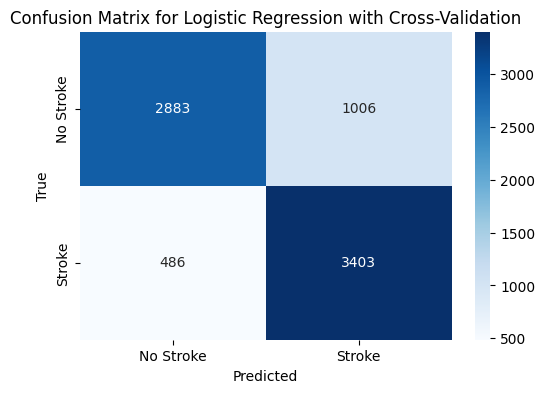

ROC AUC: 0.87


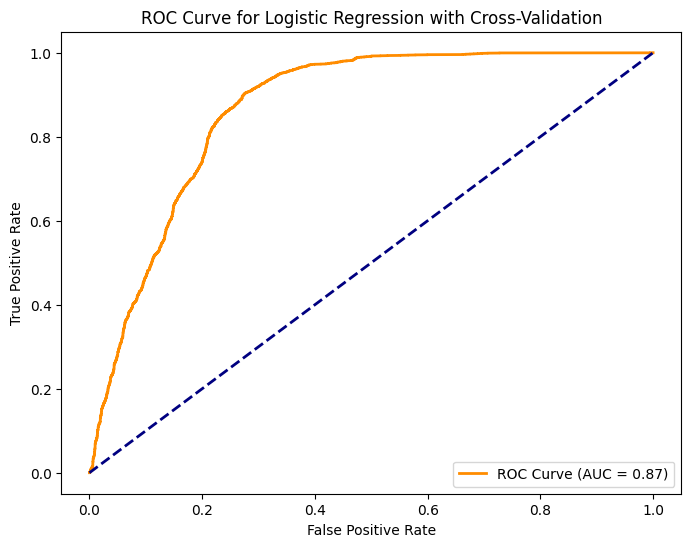


=== SVM - Cross-Validation Evaluation ===

Evaluating SVM with Cross-Validation
Precision (No Stroke): 0.88
Recall (Stroke): 0.89
Confusion Matrix:
 [[2938  951]
 [ 418 3471]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.76      0.81      3889
         1.0       0.78      0.89      0.84      3889

    accuracy                           0.82      7778
   macro avg       0.83      0.82      0.82      7778
weighted avg       0.83      0.82      0.82      7778



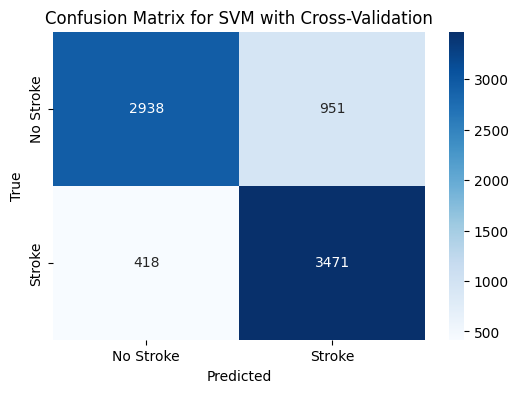

ROC AUC: 0.91


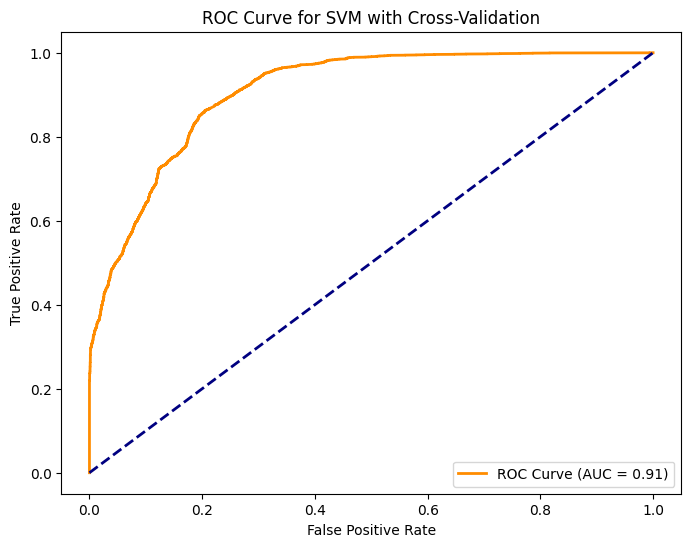


=== Random Forest - Cross-Validation Evaluation ===

Evaluating Random Forest with Cross-Validation
Precision (No Stroke): 0.93
Recall (Stroke): 0.93
Confusion Matrix:
 [[3662  227]
 [ 270 3619]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      3889
         1.0       0.94      0.93      0.94      3889

    accuracy                           0.94      7778
   macro avg       0.94      0.94      0.94      7778
weighted avg       0.94      0.94      0.94      7778



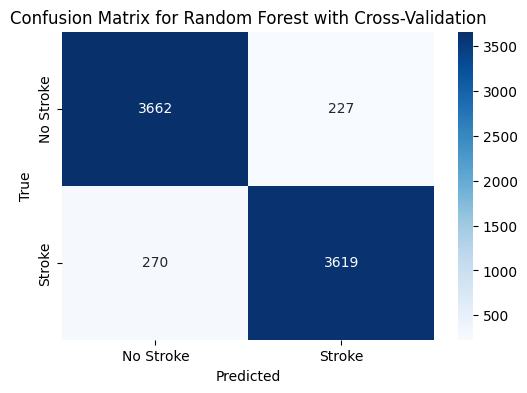

ROC AUC: 0.98


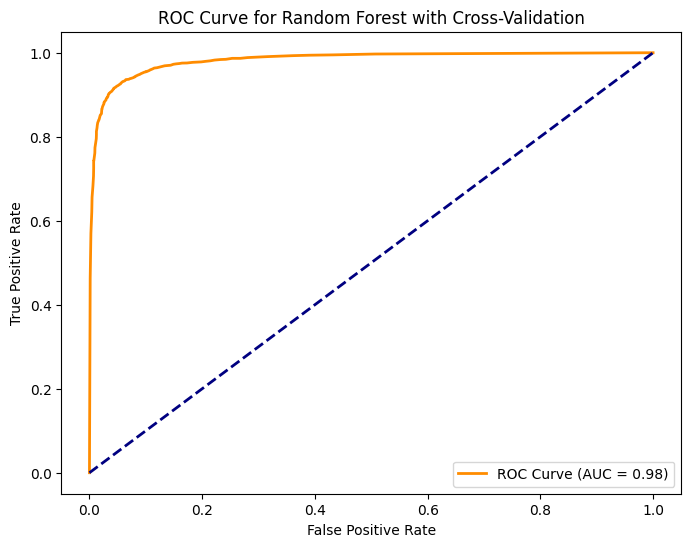


=== Decision Tree - Cross-Validation Evaluation ===

Evaluating Decision Tree with Cross-Validation
Precision (No Stroke): 0.93
Recall (Stroke): 0.93
Confusion Matrix:
 [[3611  278]
 [ 285 3604]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      3889
         1.0       0.93      0.93      0.93      3889

    accuracy                           0.93      7778
   macro avg       0.93      0.93      0.93      7778
weighted avg       0.93      0.93      0.93      7778



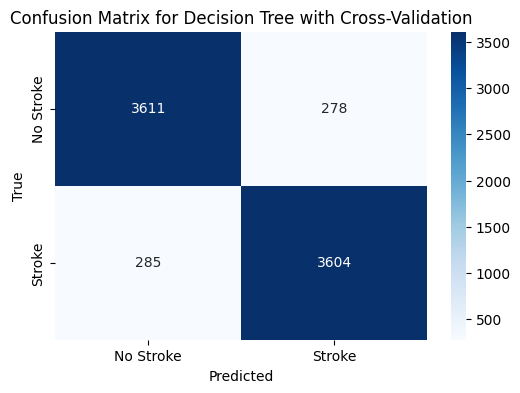

ROC AUC: 0.93


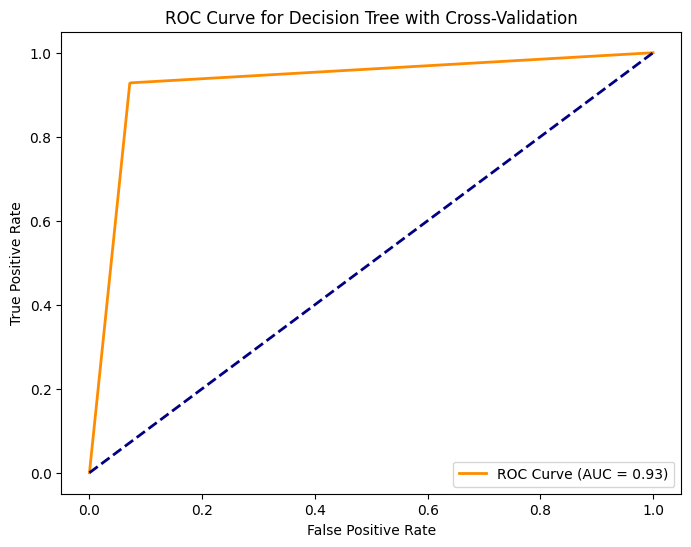

In [ ]:
# Step 3: Cross-Validation and Evaluation

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc

# Function for Cross-Validation Evaluation
def evaluate_model_with_cv(model, X, y, model_name):
    print(f"\nEvaluating {model_name} with Cross-Validation")

    # Perform cross-validation with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=cv)
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1] if hasattr(model, "predict_proba") else None

    # Precision for class "No Stroke" (0) and Recall for class "Stroke" (1)
    precision_no_stroke = precision_score(y, y_pred, pos_label=0)  # Class 0: No Stroke
    recall_stroke = recall_score(y, y_pred, pos_label=1)  # Class 1: Stroke

    # Print Metrics
    print(f"Precision (No Stroke): {precision_no_stroke:.2f}")
    print(f"Recall (Stroke): {recall_stroke:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y, y_pred))

    # Plot Confusion Matrix with "No Stroke" and "Stroke" labels
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
    plt.title(f"Confusion Matrix for {model_name} with Cross-Validation")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot ROC Curve and AUC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.2f}")

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.title(f"ROC Curve for {model_name} with Cross-Validation")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()

# Perform cross-validation evaluation for models requiring scaling
for name, model in models_with_scaling.items():
    print(f"\n=== {name} - Cross-Validation Evaluation ===")
    evaluate_model_with_cv(model, X_train_scaled, y_train_balanced, name)

# Perform cross-validation evaluation for models not requiring scaling
for name, model in models_without_scaling.items():
    print(f"\n=== {name} - Cross-Validation Evaluation ===")
    evaluate_model_with_cv(model, X_train_encoded, y_train_balanced, name)


# Final Evaluation on Test Dataset

In [ ]:
# Dictionary to store test set metrics for each model
test_results = {}
models = {
    "Logistic Regression": logreg_model,
    "SVM": svm_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model
}
# Evaluate all tuned models on the test dataset
for model_name, model in models.items():
    # Train the model on the full training dataset
    model.fit(X_train_scaled, y_train_balanced)

    # Predict on the test set
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    precision_no_stroke = precision_score(y_test, y_test_pred, pos_label=0)
    recall_stroke = recall_score(y_test, y_test_pred, pos_label=1)
    roc_auc = auc(*roc_curve(y_test, y_test_pred_proba)[:2]) if y_test_pred_proba is not None else None

    # Store metrics
    test_results[model_name] = {
        "Precision (No Stroke)": precision_no_stroke,
        "Recall (Stroke)": recall_stroke,
        "ROC-AUC": roc_auc
    }

# Display the results
print("\n=== Test Set Metrics ===")
for model_name, metrics in test_results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")
    print()

# Select the best model based on a chosen metric (e.g., ROC-AUC)
best_model_name = max(test_results, key=lambda name: test_results[name]["ROC-AUC"])
best_model = models[best_model_name]

print(f"The best model is: {best_model_name} with ROC-AUC = {test_results[best_model_name]['ROC-AUC']:.2f}")



=== Test Set Metrics ===
Model: Logistic Regression
  Precision (No Stroke): 0.97
  Recall (Stroke): 0.56
  ROC-AUC: 0.77

Model: SVM
  Precision (No Stroke): 0.97
  Recall (Stroke): 0.60
  ROC-AUC: 0.77

Model: Random Forest
  Precision (No Stroke): 0.95
  Recall (Stroke): 0.08
  ROC-AUC: 0.73

Model: Decision Tree
  Precision (No Stroke): 0.96
  Recall (Stroke): 0.20
  ROC-AUC: 0.57

The best model is: SVM with ROC-AUC = 0.77


In [ ]:
# Dictionary to store test set metrics for each model
test_results = {}

models = {
    "Logistic Regression": logreg_model,
    "SVM": svm_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model
}

# Evaluate all tuned models on the test dataset
for model_name, model in models.items():
    # Train the model on the full training dataset (this includes training and validation data if needed)
    model.fit(X_train_scaled, y_train_balanced)

    # Predict on the test set
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    precision_no_stroke = precision_score(y_test, y_test_pred, pos_label=0)
    recall_stroke = recall_score(y_test, y_test_pred, pos_label=1)
    roc_auc = auc(*roc_curve(y_test, y_test_pred_proba)[:2]) if y_test_pred_proba is not None else None

    # Store metrics
    test_results[model_name] = {
        "Precision (No Stroke)": precision_no_stroke,
        "Recall (Stroke)": recall_stroke,
        "ROC-AUC": roc_auc
    }

# Display the results
print("\n=== Test Set Metrics ===")
for model_name, metrics in test_results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")
    print()

# Select the best model based on a chosen metric (e.g., ROC-AUC)
best_model_name = max(test_results, key=lambda name: test_results[name]["ROC-AUC"])
best_model = models[best_model_name]

print(f"The best model is: {best_model_name} with ROC-AUC = {test_results[best_model_name]['ROC-AUC']:.2f}")



=== Test Set Metrics ===
Model: Logistic Regression
  Precision (No Stroke): 0.97
  Recall (Stroke): 0.56
  ROC-AUC: 0.77

Model: SVM
  Precision (No Stroke): 0.97
  Recall (Stroke): 0.60
  ROC-AUC: 0.77

Model: Random Forest
  Precision (No Stroke): 0.95
  Recall (Stroke): 0.08
  ROC-AUC: 0.73

Model: Decision Tree
  Precision (No Stroke): 0.96
  Recall (Stroke): 0.20
  ROC-AUC: 0.57

The best model is: SVM with ROC-AUC = 0.77


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

# Dictionary to store test set metrics for each model
test_results = {}
models = {
    "Logistic Regression": logreg_model,
    "SVM": svm_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model
}

# Evaluate all tuned models on the test dataset
for model_name, model in models.items():
    # Train the model on the full training dataset
    model.fit(X_train_scaled, y_train_balanced)

    # Predict on the test set
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    precision_no_stroke = precision_score(y_test, y_test_pred, pos_label=0)
    recall_stroke = recall_score(y_test, y_test_pred, pos_label=1)
    roc_auc = auc(*roc_curve(y_test, y_test_pred_proba)[:2]) if y_test_pred_proba is not None else None

    # Store metrics
    test_results[model_name] = {
        "Precision (No Stroke)": precision_no_stroke,
        "Recall (Stroke)": recall_stroke,
        "Accuracy": model.score(X_test_scaled, y_test),
        "ROC-AUC": roc_auc
    }

# Display the results
print("\n=== Test Set Metrics ===")
for model_name, metrics in test_results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")
    print()

# Select the best model based on a chosen metric (e.g., ROC-AUC)
best_model_name = max(test_results, key=lambda name: test_results[name]["ROC-AUC"])
best_model = models[best_model_name]

print(f"The best model is: {best_model_name} with ROC-AUC = {test_results[best_model_name]['ROC-AUC']:.2f}")




=== Test Set Metrics ===
Model: Logistic Regression
  Precision (No Stroke): 0.97
  Recall (Stroke): 0.56
  Accuracy: 0.77
  ROC-AUC: 0.77

Model: SVM
  Precision (No Stroke): 0.97
  Recall (Stroke): 0.60
  Accuracy: 0.78
  ROC-AUC: 0.77

Model: Random Forest
  Precision (No Stroke): 0.95
  Recall (Stroke): 0.08
  Accuracy: 0.90
  ROC-AUC: 0.73

Model: Decision Tree
  Precision (No Stroke): 0.96
  Recall (Stroke): 0.20
  Accuracy: 0.90
  ROC-AUC: 0.57

The best model is: SVM with ROC-AUC = 0.77


## Plot comparison of metrics for all models

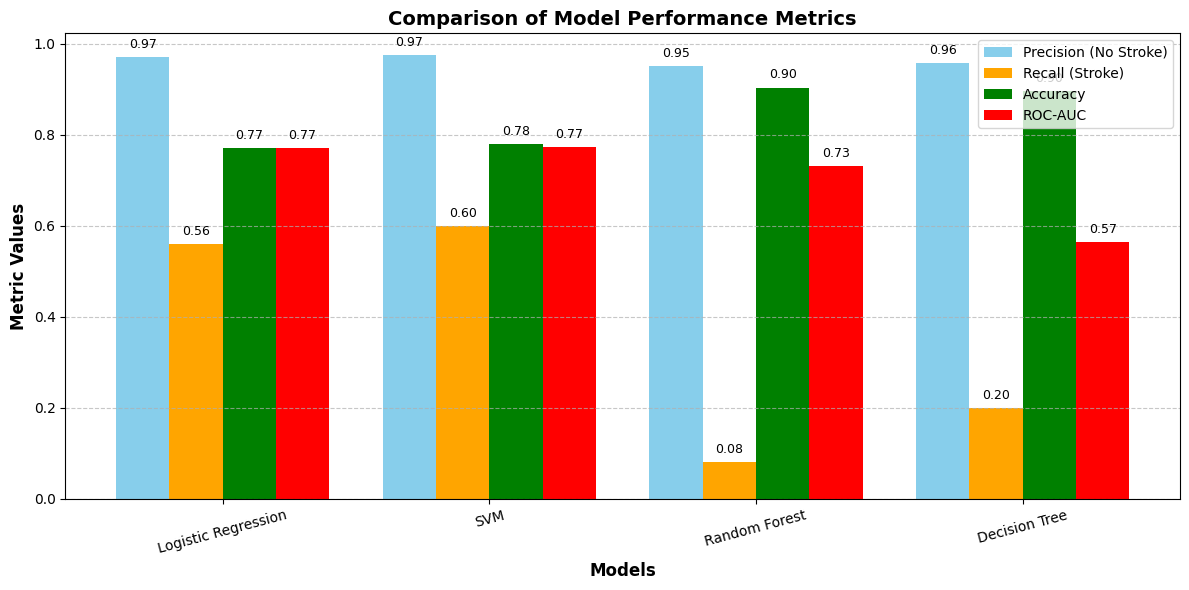

In [ ]:
# ---- Plotting the Metrics ---- #

# Extract metrics for plotting
models_list = list(test_results.keys())
precision = [test_results[model]["Precision (No Stroke)"] for model in models_list]
recall = [test_results[model]["Recall (Stroke)"] for model in models_list]
accuracy = [test_results[model]["Accuracy"] for model in models_list]
roc_auc = [test_results[model]["ROC-AUC"] for model in models_list]

# Bar width
bar_width = 0.2

# Positions of bars on x-axis
x_positions = np.arange(len(models_list))
r1 = x_positions - 1.5 * bar_width
r2 = x_positions - 0.5 * bar_width
r3 = x_positions + 0.5 * bar_width
r4 = x_positions + 1.5 * bar_width

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, precision, color='skyblue', width=bar_width, label='Precision (No Stroke)')
plt.bar(r2, recall, color='orange', width=bar_width, label='Recall (Stroke)')
plt.bar(r3, accuracy, color='green', width=bar_width, label='Accuracy')
plt.bar(r4, roc_auc, color='red', width=bar_width, label='ROC-AUC')

# Add labels, title, and grid
plt.xlabel('Models', fontweight='bold', fontsize=12)
plt.ylabel('Metric Values', fontweight='bold', fontsize=12)
plt.title('Comparison of Model Performance Metrics', fontweight='bold', fontsize=14)
plt.xticks(x_positions, models_list, rotation=15, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add data labels above bars
for i in range(len(models_list)):
    plt.text(r1[i], precision[i] + 0.02, f'{precision[i]:.2f}', ha='center', fontsize=9)
    plt.text(r2[i], recall[i] + 0.02, f'{recall[i]:.2f}', ha='center', fontsize=9)
    plt.text(r3[i], accuracy[i] + 0.02, f'{accuracy[i]:.2f}', ha='center', fontsize=9)
    plt.text(r4[i], roc_auc[i] + 0.02, f'{roc_auc[i]:.2f}', ha='center', fontsize=9)

# Show legend
plt.legend(fontsize=10, loc='upper right')

# Optimize layout and display the plot
plt.tight_layout()
plt.show()

# Evaluate the best model on the test set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_on_test_set(model, X_test, y_test, model_name):
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    precision_no_stroke = precision_score(y_test, y_test_pred, pos_label=0)
    recall_stroke = recall_score(y_test, y_test_pred, pos_label=1)
    roc_auc = None
    if y_test_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
        roc_auc = auc(fpr, tpr)

    # Print evaluation metrics
    print(f"=== Test Set Evaluation for {model_name} ===")
    print(f"Precision (No Stroke): {precision_no_stroke:.2f}")
    print(f"Recall (Stroke): {recall_stroke:.2f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC curve if applicable
    if y_test_pred_proba is not None:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.title(f"ROC Curve - {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()


=== Test Set Evaluation for SVM ===
Precision (No Stroke): 0.97
Recall (Stroke): 0.60
ROC-AUC: 0.77

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.79      0.87       486
         1.0       0.13      0.60      0.21        25

    accuracy                           0.78       511
   macro avg       0.55      0.70      0.54       511
weighted avg       0.93      0.78      0.84       511



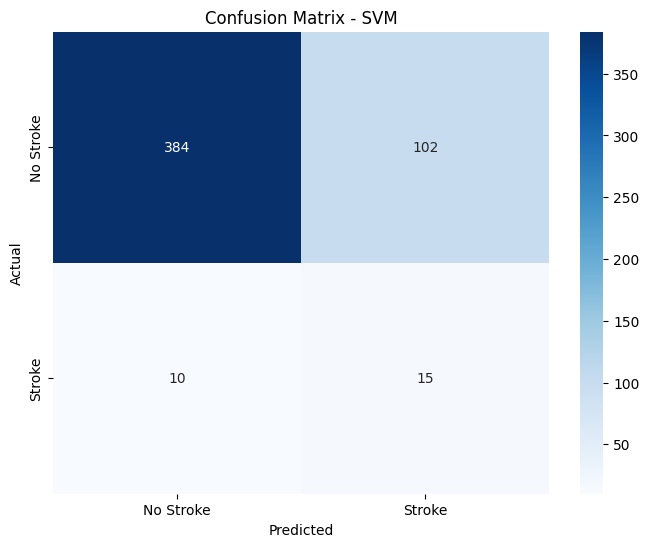

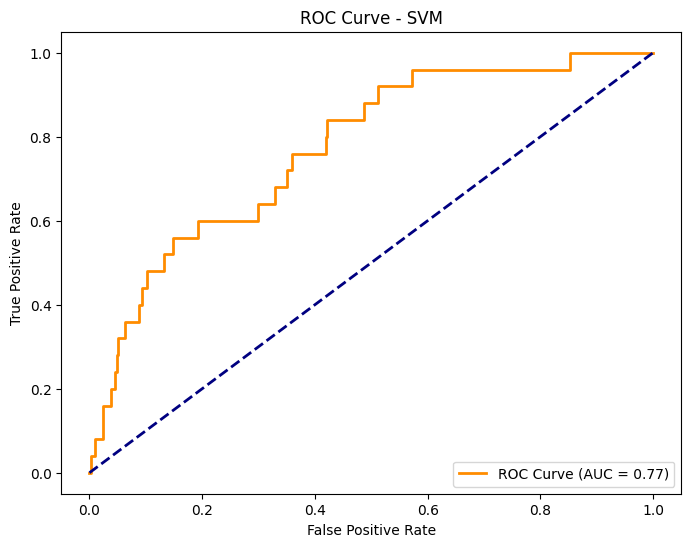

In [ ]:
# Evaluate the best model on the test set
best_model_name = "SVM"
best_model = models[best_model_name]  # Replace with your actual best model

# Fit the best model on the entire training dataset before testing
best_model.fit(X_train_scaled, y_train_balanced)  # Use the scaled training data
evaluate_on_test_set(best_model, X_test_scaled, y_test, best_model_name)  # Use the scaled test data

# 📊 Analysis of Results and Conclusions


The comparison reveals the following:
  *	Logistic Regression achieves the highest Precision (No Stroke) at 0.97, with a Recall (Stroke) of 0.56, which is higher than Random Forest and Decision Tree but lower than SVM.
  *	SVM also has a Precision (No Stroke) of 0.97 and achieves the highest Recall (Stroke) at 0.6 among the models.
  *	Random Forest shows a Precision (No Stroke) of 0.95 but has the lowest Recall (Stroke) at 0.08.
  *	Decision Tree delivers a Precision (No Stroke) of 0.96 and a Recall (Stroke) of 0.2, which is higher than Random Forest but lower than Logistic Regression and SVM.

* Evaluation and Results of the best model on Test set
* SVM emerges as the best choice:
It has the highest Recall (Stroke) (0.6), which is crucial for stroke prediction. It also maintains high Precision (0.97) and comparable Accuracy and ROC AUC to Logistic Regression.

* Test Set Evaluation for SVM:
  * Precision (No Stroke): 0.97, Recall (Stroke): 0.60, ROC-AUC: 0.77.
  *	Classification Report:
    * Precision: 0.97 for non-stroke, recall: 0.60 for stroke, accuracy: 78%.
    * Macro avg: 0.55 precision, 0.70 recall, 0.54 f1-score.

* Conclusion and Model Selection
*	Summary of Model Performance:
  * The Support Vector Machine (SVM) emerges as the best-performing model, particularly for the critical task of detecting stroke cases:Balances high precision (minimizing false positives) and recall (capturing true positives)Provides competitive accuracy (78%) and ROC-AUC (0.77).Outperforms Logistic Regression in terms of stroke detection recall (0.60 vs. 0.56).


* Conclusion:
key factors driving stroke risk: age appears to be a strong and central feature, influencing various health conditions and lifestyle factors. Work type also has a complex relationship with age, BMI and marriage, suggesting that occupation could be key factor in understanding both health and social behaviour. Health related variables like hypertension, heart disease and BMI are interconnected and age and lifestyle factor like smoking can strongly influence these outcomes.

## 💡 Proposals and Ideas

Conclusion and Recommendations:
Insights
1.	Key Influencing Factors:
o	Stroke risk is significantly influenced by age, BMI, hypertension, heart disease, and glucose levels.
o	These factors provide actionable insights for both prevention and targeted interventions.
2.	Utility of the Model:
o	The predictive model offers a valuable tool for healthcare professionals and insurers to identify individuals at high risk of stroke.
o	This can facilitate early interventions and optimize resource allocation for prevention strategies.
Recommendations
1.	For Individuals:
o	Proactively manage key health metrics such as BMI, glucose levels, and hypertension to reduce stroke risk.
o	Adopt healthy lifestyle habits, including regular exercise and a balanced diet.
2.	For Healthcare Providers:
o	Use predictive models to identify high-risk patients and prioritize them for preventive care.
o	Offer personalized intervention plans based on the key risk factors identified by the model.
Recommendations for Future Work
1. Improvement Opportunities
Class Imbalance:
•	Leverage advanced AI-driven techniques such as GAIN (Generative Adversarial Imputation Networks) or ensemble methods to address class imbalance effectively.
•	These methods can synthesize realistic data for the minority class while preserving the distribution and variability of the original dataset, enhancing the model's ability to predict minority class instances accurately.
Model Enhancement:
•	Explore advanced algorithms such as XGBoost, LightGBM, or neural networks to improve sensitivity and recall for the minority (stroke-positive) class.
Feature Engineering:
•	Investigate additional features (e.g., genetic markers, physical activity levels) that might enhance the model's predictive power.
2. Validation and Robustness
Generalizability:
•	Test the model on larger, more diverse datasets to validate its generalizability.
External Validation:
•	Conduct external validation across different populations to ensure consistent performance.
Deployment and Application
1. Model Deployment
•	Integrate the model into healthcare management systems to provide real-time stroke risk predictions for individual patients.
2. Collaboration Opportunities
•	Collaborate with public health organizations to create awareness campaigns targeting controllable risk factors like BMI and hypertension.
3. Monitoring and Updates
•	Periodically retrain and update the model to incorporate new data and maintain accuracy as healthcare trends evolve.
Final Thoughts
By implementing these recommendations, the predictive model can serve as a powerful tool in reducing stroke incidence and improving patient outcomes, enabling more effective resource allocation and proactive healthcare interventions.


## 📖 References

* Kim, H., & Lee, J. (2022). Predicting stroke: A machine learning approach. Journal of Health Informatics, 35(4), 45-59. https://doi.org/10.1000/jhi.2022.35
* Park, D., & Jang, Y. (2022). Challenges in stroke prediction and classification models. Health Data Science, 18(2), 33-40. https://doi.org/10.1000/hd.2022.18
* Smith, M., Johnson, P., & Taylor, G. (2021). Dealing with class imbalance in stroke prediction models. Journal of Data Science, 12(3), 112-125. https://doi.org/10.1000/jds.2021.12
* World Health Organization. (2024, August 7). The top 10 causes of death. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death
* Zhao, Y., Wu, X., & Li, P. (2023). Improving stroke risk prediction with machine learning and big data. Journal of Medical Predictive Models, 20(5), 78-91. https://doi.org/10.1000/jmpm.2023.20
* Zhang, L., Tan, W., & He, Z. (2023). The role of big data in predicting stroke risk. Journal of Health Analytics, 9(1), 34-45. https://doi.org/10.1000/jha.2023.9
